In [2]:
# Importing necessary libraries

# Core data manipulation and analysis
import pandas as pd  # For handling data in DataFrames
import numpy as np   # For numerical operations with arrays
import anndata as ad  # For working with Annotated Data (AnnData) objects

# Single-cell analysis tools
import scanpy as sc  # Provides a comprehensive single-cell analysis workflow

# Visualization libraries
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from matplotlib.lines import Line2D  # For adding custom lines to plots
import seaborn as sns  # For creating statistically informative and visually appealing plots

# Machine learning and dimensionality reduction
from sklearn.manifold import TSNE, trustworthiness  # For t-SNE dimensionality reduction and evaluating its trustworthiness
import umap  # For UMAP dimensionality reduction
from sklearn.metrics import pairwise_distances  # For calculating distances between data points
from sklearn.mixture import GaussianMixture  # For Gaussian Mixture Model clustering
from sklearn.cluster import AgglomerativeClustering, SpectralClustering  # For hierarchical and spectral clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score  # For evaluating clustering performance

# Statistical analysis
from scipy.stats import uniform, randint  # For generating random numbers from uniform and discrete uniform distributions
from sklearn.model_selection import ParameterSampler  # For parameter tuning using random search

# Gene set enrichment analysis
from gprofiler import GProfiler  # For performing functional enrichment analysis of gene lists

# Handling warnings
import warnings  # For managing warning messages
warnings.filterwarnings('ignore')  # Ignoring warning messages for cleaner output

# Add project root to Python path
import sys  # For system-specific parameters and functions
import os  # For interacting with the operating system
project_dir = "/Users/elifhamali/scRNAseq-Pipeline-GastricCancer"  # Replace with your project directory
if project_dir not in sys.path:
    sys.path.append(project_dir)  # Adding the project directory to the system path

# Import our processor
from src.preprocessing.data_processor import SingleCellProcessor  # Importing a custom class for data preprocessing

# Introduction

This notebook reproduces and extends the analysis of gastric cancer (GC)  single-cell RNA-seq (scRNA-seq) data from the study:

*  "Comprehensive analysis of metastatic gastric cancer tumour cells using single‑cell RNA‑seq" by Wang B. et. al.  [https://www.nature.com/articles/s41598-020-80881-2](https://www.nature.com/articles/s41598-020-80881-2)

Raw count data is obtained from the Gene Expression Omnibus (GEO): 

*  GSE158631 [https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158631](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158631)

As the original authors' code was not available, this notebook provides a reimplementation of their analysis pipeline, with potential additions and modifications.

The analysis pipeline includes the following steps:

1. Data Preprocessing:
    * Quality control (QC) metrics calculation
    * Normalization of gene expression
    * Filtering of low-quality cells and genes

2. Dimensionality Reduction:
    * Principal Component Analysis (PCA)
    * t-distributed Stochastic Neighbor Embedding (t-SNE)
    * Uniform Manifold Approximation and Projection (UMAP)

3. Clustering:
    * Gaussian Mixture Models (GMMs)
    * Hierarchical clustering (Average Link, Ward)
    * Spectral clustering
    * Louvain and Leiden community detection algorithms

4. Post-Clustering Analysis:
    * Identification of marker genes for each cluster
    * Functional annotation of clusters using Gene Ontology (GO) enrichment analysis 

## The `GCSingleCellAnalysis` Class

* The `GCSingleCellAnalysis` class provides a comprehensive pipeline for 
  analyzing gastric cancer (GC) scRNA-seq data. It utilizes the AnnData 
  object ([https://anndata.readthedocs.io/en/latest/](https://anndata.readthedocs.io/en/latest/)) for data storage 
  and the Scanpy library ([https://scanpy.readthedocs.io/en/stable/](https://scanpy.readthedocs.io/en/stable/)) for 
  single-cell analysis tasks.

    Here's a summary of the class methods:

    Data Loading and Management:
        * `__init__(self, filepath=None)`: 
            * Initializes the class and loads data from a CSV file into an AnnData object.
        * `save_adata(self, filename)`: 
            * Saves the AnnData object to an h5ad file.
        * `load_adata(self, filename)`:
            * Loads an AnnData object from an h5ad file.

    Preprocessing:
        * `preprocess_adata(self)`: 
            * Adds gene annotations (mitochondrial, ribosomal, hemoglobin) and calculates QC metrics.
        * `normalize_adata(self)`: 
            * Normalizes the data using TPM and log2 transformation (if raw counts).
        * `filter_adata(self, ribosomal_threshold=50, mitochondrial_threshold=20)`: 
            * Filters cells and genes based on QC thresholds.
        * `prepare_adata(self)`: 
            * Extracts patient and tissue information, creating a 'cell_type' column.

    Dimensionality Reduction:
        * `perform_pca(self, n_comps=50)`: 
            * Performs PCA on the data.
        * `determine_optimal_pcs(self, variance_threshold=0.90)`: 
            * Determines the optimal number of PCs based on explained variance.
        * `prepare_pca_reduced_adata(self, variance_threshold=0.90)`:
            * Creates a reduced AnnData object with the optimal PCs.
        * `plot_pca(self)`: 
            * Generates PCA scatter plots and histograms.
        * `optimize_tsne(self, n_iter=30, random_state=42)`: 
            * Optimizes t-SNE hyperparameters using trustworthiness.
        * `perform_tsne(self, optimize=False, n_iter=30, random_state=42, **kwargs)`: 
            * Performs t-SNE with optional hyperparameter optimization.
        * `plot_tsne(self)`: 
            * Plots the t-SNE results.
        * `optimize_umap(self, n_iter=30, random_state=42)`: 
            * Optimizes UMAP hyperparameters using trustworthiness.
        * `perform_umap(self, optimize=False, n_iter=30, random_state=42, **kwargs)`: 
            * Performs UMAP with optional hyperparameter optimization.
        * `plot_umap(self)`: 
            * Plots the UMAP results.

    Clustering:
        * `apply_clustering(self, data, method='gmm', n_clusters=4, embedding='X_pca', optimize=False)`: 
            * Applies various clustering methods (GMM, hierarchical, spectral, Louvain, Leiden).
        * `evaluate_clustering(self, labels, data)`: 
            * Evaluates clustering performance using different metrics.
        * `cluster_and_evaluate(self, methods, embeddings=['X_pca'], optimize=False)`: 
            * Performs clustering and evaluation for multiple methods and embeddings.
        * `create_results_dataframe(self, results)`: 
            * Creates a DataFrame to store clustering results.
        * `plot_clustering_evaluation(self, results_df)`: 
            * Visualizes clustering evaluation metrics.

    Post-Clustering Analysis:
        * `analyze_and_plot_markers(self, group_key, method='wilcoxon', n_genes=10, filename='marker_genes.csv', figsize=(10, 7))`: 
            * Identifies and visualizes marker genes for clusters.
        * `fetch_go_annotations(self, group_key, method='wilcoxon', n_genes=10, organism='hsapiens')`: 
            * Retrieves GO annotations for marker genes using gprofiler.
        * `print_go_annotations(self, go_annotations)`: 
            * Displays the GO annotations.

In [3]:
# Initialize the SingleCellProcessor object

# Define the path to the raw count data
data_path = "/Users/elifhamali/scRNAseq-Pipeline-GastricCancer/data/raw/GSE158631_count.csv"  

# Create an instance of the SingleCellProcessor with the data path
analysis = SingleCellProcessor(data_path)  

# Verify successful data loading and display basic information
if analysis.adata is not None:  # Check if the AnnData object was created
    print(f"Data loaded successfully:")  
    print(f"Number of cells: {analysis.adata.n_obs}")  # Print the number of cells
    print(f"Number of genes: {analysis.adata.n_vars}")  # Print the number of genes

Data loaded successfully:
Number of cells: 94
Number of genes: 21196


In [4]:
# Display the AnnData object summary
print(analysis.adata)  

# Convert the AnnData object to a pandas DataFrame for inspection
adata_df = analysis.adata.to_df()  
print(adata_df.head())  # Print the first few rows of the DataFrame

AnnData object with n_obs × n_vars = 94 × 21196
         THY1  DCN  COL1A1  COL1A2  COL6A1  COL6A2  COL6A3  PECAM1  VWF  CDH5  \
GC1-TT1     0    0       0       1       0       0       1      10   11     0   
GC1-TT2     0    0       0       1       0       0       0       1    3     0   
GC1-TT3     0    0       0       1       0       0      12       0   14     0   
GC1-TT4     0    0       0      10       0       0       1       2    0     4   
GC1-TT5     0    0       0       5       0       0      13       0    0     0   

         ...  RPS4Y2  RBMY2EP  TTTY13  TTTY6  TTTY5  RBMY2FP  DAZ1  DAZ4  \
GC1-TT1  ...       0        0       0      0      0        0     0     0   
GC1-TT2  ...       0        0       0      0      2        0     0     0   
GC1-TT3  ...       0        0       2      0      0        0     1     0   
GC1-TT4  ...       0        1       0      0      0        3     0     1   
GC1-TT5  ...       0        0       0      0      0        0     0     0   

        

* Preprocessing: Extracting Gene Information and Calculating QC Metrics

    * The first step in our preprocessing workflow involves identifying 
      mitochondrial, ribosomal, and hemoglobin genes within the dataset. 
      These gene sets are important for quality control and can provide 
      insights into the biological state of the cells.

    * We use the `preprocess_adata()` method to calculate a range of QC metrics 
      for both cells and genes. These metrics include:

        Cell-level QC metrics:
            * Total counts: The overall expression level of a cell.
            * Total counts for QC genes: Expression of mitochondrial, ribosomal, and hemoglobin genes.
            * Percentage counts for QC genes: The proportion of total counts attributed to these gene sets.
            * Number of genes detected: The overall gene diversity expressed in a cell.
            * Number of QC genes detected: The number of detected genes from the QC gene sets.

        Gene-level QC metrics:
            * Total counts: The overall expression level of a gene across all cells.
            * Number of cells expressing the gene: A measure of gene ubiquity.
            * Mean counts: The average expression level of a gene.
            * Percentage counts: The proportion of total counts attributed to a specific gene.

    * Why focus on mitochondrial, ribosomal, and hemoglobin genes?

        * Mitochondrial Genes: 
            * High mitochondrial gene expression can be a sign of cellular stress or apoptosis.
            * Filtering cells with excessive mitochondrial content can improve data quality.

        * Ribosomal Genes: 
            * High ribosomal gene expression can indicate technical artifacts (doublets, high background).
            * Filtering cells with excessive ribosomal content helps focus on biologically relevant signals.

        * Hemoglobin Genes:
            * Hemoglobin expression is linked to tumor progression and prognosis in gastric cancer.
            * Including hemoglobin genes in the analysis may help identify clinically relevant cell subpopulations.

In [5]:
# Preprocessing the data and calculating QC metrics
analysis.preprocess_adata()

In [6]:
# Displaying the QC metrics for each cell
analysis.adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
GC1-TT1                4584                 8.430545         15044   
GC1-TT2                5153                 8.547528         24631   
GC1-TT3                5633                 8.636575         19521   
GC1-TT4                4958                 8.508959         20751   
GC1-TT5                3960                 8.284252         16139   
...                     ...                      ...           ...   
GC3-LN8                3760                 8.232440          9270   
GC3-LN9                4663                 8.447629         11077   
GC3-LN10               4178                 8.337827          9912   
GC3-LN11               3590                 8.186186         10841   
GC3-LN12               1625                 7.393878          7607   

          log1p_total_counts  pct_counts_in_top_50_genes  \
GC1-TT1             9.618801                   10.821590   
GC1-TT2            10.111802                    7.904673   
GC1-TT3             9.879297                    6.838789   
GC1-TT4             9.940398                    8.674281   
GC1-TT5             9.689056                   10.558275   
...                      ...                         ...   
GC3-LN8             9.134647                    9.719525   
GC3-LN9             9.312716                    6.752731   
GC3-LN10            9.201602                    7.627119   
GC3-LN11            9.291183                    9.750023   
GC3-LN12            8.936956                   23.294334   

          pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
GC1-TT1                     15.919968                    23.756980   
GC1-TT2                     13.231294                    21.326783   
GC1-TT3                     11.479945                    18.718303   
GC1-TT4                     14.211363                    22.476025   
GC1-TT5                     16.103848                    24.852841   
...                               ...                          ...   
GC3-LN8                     14.994606                    22.718447   
GC3-LN9                     10.887424                    17.703349   
GC3-LN10                    12.378935                    19.733656   
GC3-LN11                    15.810350                    24.942348   
GC3-LN12                    34.810043                    49.533325   

          pct_counts_in_top_500_genes  total_counts_mt  log1p_total_counts_mt  \
GC1-TT1                     40.268546                0                    0.0   
GC1-TT2                     37.793837                0                    0.0   
GC1-TT3                     33.722658                0                    0.0   
GC1-TT4                     39.540263                0                    0.0   
GC1-TT5                     42.920875                0                    0.0   
...                               ...              ...                    ...   
GC3-LN8                     39.212513                0                    0.0   
GC3-LN9                     32.734495                0                    0.0   
GC3-LN10                    35.794996                0                    0.0   
GC3-LN11                    43.252467                0                    0.0   
GC3-LN12                    73.287761                0                    0.0   

          pct_counts_mt  total_counts_ribo  log1p_total_counts_ribo  \
GC1-TT1             0.0                145                 4.983607   
GC1-TT2             0.0                106                 4.672829   
GC1-TT3             0.0                 81                 4.406719   
GC1-TT4             0.0                 57                 4.060443   
GC1-TT5             0.0                161                 5.087596   
...                 ...                ...                      ...   
GC3-LN8             0.0                 24                 3.218876   
GC3-LN9             0.0                 38                 3.66356

In [7]:
# Displaying the QC metrics for each gene
analysis.adata.var

mt   ribo     hb  n_cells_by_counts  mean_counts  \
THY1     False  False  False                 22     0.904255   
DCN      False  False  False                 32     0.936170   
COL1A1   False  False  False                 36     1.489362   
COL1A2   False  False  False                 56     2.765957   
COL6A1   False  False  False                 13     0.712766   
...        ...    ...    ...                ...          ...   
RBMY2FP  False  False  False                  7     0.159574   
DAZ1     False  False  False                  3     0.031915   
DAZ4     False  False  False                  3     0.031915   
DAZ2     False  False  False                  5     0.053191   
DAZ3     False  False  False                 49     0.819149   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
THY1              0.644091              76.595745            85   
DCN               0.660712              65.957447            88   
COL1A1            0.912026              61.702128           140   
COL1A2            1.326002              40.425532           260   
COL6A1            0.538110              86.170213            67   
...                    ...                    ...           ...   
RBMY2FP           0.148053              92.553191            15   
DAZ1              0.031416              96.808511             3   
DAZ4              0.031416              96.808511             3   
DAZ2              0.051825              94.680851             5   
DAZ3              0.598369              47.872340            77   

         log1p_total_counts  
THY1               4.454347  
DCN                4.488636  
COL1A1             4.948760  
COL1A2             5.564520  
COL6A1             4.219508  
...                     ...  
RBMY2FP            2.772589  
DAZ1               1.386294  
DAZ4               1.386294  
DAZ2               1.791759  
DAZ3               4.356709  

[21196 rows x 9 columns]

* Data Normalization: TPM and Log2 Transformation

    * Following the original study's pipeline, we normalize the raw read counts 
      using Transcripts Per Million (TPM) normalization and then apply a log2 
      transformation.

    * Why TPM normalization?
        * TPM accounts for both gene length and sequencing depth, making gene expression 
          levels comparable across different genes and samples.

    * Why log2 transformation?
        * Log2 transformation stabilizes variance and helps normalize the distribution 
          of the data, improving the performance of downstream analyses.

    * The `normalize_adata()` method includes a check to determine if the data 
      has already been normalized. If so, it skips the normalization steps to 
      prevent unnecessary processing.


In [8]:
# Normalizing the data (TPM and log2 transformation)
analysis.normalize_adata()

Data was normalized to TPM and log2 transformed.


In [9]:
print(analysis.adata) # checking the shape of the AnnData object (cells x genes)
analysis.adata.to_df() # displaying the AnnData object as a dataframe

AnnData object with n_obs × n_vars = 94 × 21196
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


THY1       DCN    COL1A1    COL1A2    COL6A1  COL6A2    COL6A3  \
GC1-TT1   0.000000  0.000000  0.000000  6.076210  0.000000     0.0  6.076210   
GC1-TT2   0.000000  0.000000  0.000000  5.378485  0.000000     0.0  0.000000   
GC1-TT3   0.000000  0.000000  0.000000  5.706721  0.000000     0.0  9.266137   
GC1-TT4   0.000000  0.000000  0.000000  8.915594  0.000000     0.0  5.620306   
GC1-TT5   0.000000  0.000000  0.000000  8.279882  0.000000     0.0  9.655535   
...            ...       ...       ...       ...       ...     ...       ...   
GC3-LN8   0.000000  6.766527  0.000000  9.562479  0.000000     0.0  0.000000   
GC3-LN9   6.512182  0.000000  9.305925  8.821410  6.512182     0.0  6.512182   
GC3-LN10  0.000000  0.000000  0.000000  0.000000  6.670838     0.0  6.670838   
GC3-LN11  0.000000  7.535157  7.535157  6.542914  7.535157     0.0  6.542914   
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000     0.0  0.000000   

            PECAM1        VWF     CDH5  ...  RPS4Y2   RBMY2EP    TTTY13  \
GC1-TT1   9.378765   9.516071  0.00000  ...     0.0  0.000000  0.000000   
GC1-TT2   5.378485   6.940140  0.00000  ...     0.0  0.000000  0.000000   
GC1-TT3   0.000000   9.488194  0.00000  ...     0.0  0.000000  6.692842   
GC1-TT4   6.605567   0.000000  7.59814  ...     0.0  5.620306  0.000000   
GC1-TT5   0.000000   0.000000  0.00000  ...     0.0  0.000000  0.000000   
...            ...        ...      ...  ...     ...       ...       ...   
GC3-LN8   0.000000   9.340405  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN9   0.000000   0.000000  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN10  0.000000   6.670838  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN11  0.000000   7.535157  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN12  0.000000  11.739318  0.00000  ...     0.0  0.000000  0.000000   

          TTTY6    TTTY5   RBMY2FP      DAZ1      DAZ4  DAZ2      DAZ3  
GC1-TT1     0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.076210  
GC1-TT2     0.0  6.36104  0.000000  0.000000  0.000000   0.0  5.378485  
GC1-TT3     0.0  0.00000  0.000000  5.706721  0.000000   0.0  0.000000  
GC1-TT4     0.0  0.00000  7.185583  0.000000  5.620306   0.0  5.620306  
GC1-TT5     0.0  0.00000  0.000000  0.000000  0.000000   0.0  7.959114  
...         ...      ...       ...       ...       ...   ...       ...  
GC3-LN8     0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  
GC3-LN9     0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.512182  
GC3-LN10    0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  
GC3-LN11    0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.542914  
GC3-LN12    0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  

[94 rows x 21196 columns]

* Filtering Cells and Genes

    * After normalization, we apply filtering steps to remove low-quality cells 
      and genes that could negatively impact downstream analyses. This is done 
      using the `filter_adata()` method, which implements the following filters:

        Gene Filtering:
            * Minimum Average Expression:  Genes with an average expression level of less 
              than 1 count across all cells are removed. This helps to focus on genes 
              that are expressed at a detectable level.

        Cell Filtering:
            * Mitochondrial Gene Expression: Cells with more than 20% of their total 
              counts originating from mitochondrial genes are removed. High mitochondrial 
              gene expression can indicate cellular stress or damage.
            * Ribosomal Gene Expression: Cells with more than 50% of their total counts 
              originating from ribosomal genes are removed. High ribosomal gene expression 
              can be a sign of technical artifacts.

    * Note: The threshold values for mitochondrial and ribosomal gene expression 
      can be adjusted based on the specific characteristics of the dataset and the 
      goals of the analysis. 

In [10]:
# Filtering the data based on the QC metrics
analysis.filter_adata(ribosomal_threshold=50, mitochondrial_threshold=20) # 50% threshold for ribosomal genes and 20% threshold for mitochondrial genes

Number of genes before applying gene filtering: 21196
Number of genes after applying gene filtering: 11500
Number of cells before filtering high mitochondrial content: 94
Number of cells after filtering high mitochondrial content: 94
Number of cells before filtering high ribosomal content: 94
Number of cells after filtering high ribosomal content: 94


In [11]:
print(analysis.adata) # checking the shape of the AnnData object (cells x genes)
analysis.adata.to_df() # displaying the AnnData object as a dataframe

View of AnnData object with n_obs × n_vars = 94 × 11500
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


THY1       DCN    COL1A1    COL1A2    COL6A1  COL6A2    COL6A3  \
GC1-TT1   0.000000  0.000000  0.000000  6.076210  0.000000     0.0  6.076210   
GC1-TT2   0.000000  0.000000  0.000000  5.378485  0.000000     0.0  0.000000   
GC1-TT3   0.000000  0.000000  0.000000  5.706721  0.000000     0.0  9.266137   
GC1-TT4   0.000000  0.000000  0.000000  8.915594  0.000000     0.0  5.620306   
GC1-TT5   0.000000  0.000000  0.000000  8.279882  0.000000     0.0  9.655535   
...            ...       ...       ...       ...       ...     ...       ...   
GC3-LN8   0.000000  6.766527  0.000000  9.562479  0.000000     0.0  0.000000   
GC3-LN9   6.512182  0.000000  9.305925  8.821410  6.512182     0.0  6.512182   
GC3-LN10  0.000000  0.000000  0.000000  0.000000  6.670838     0.0  6.670838   
GC3-LN11  0.000000  7.535157  7.535157  6.542914  7.535157     0.0  6.542914   
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000     0.0  0.000000   

            PECAM1        VWF     CDH5  ...      PRKY    TTTY15     USP9Y  \
GC1-TT1   9.378765   9.516071  0.00000  ...  6.076210  0.000000  6.076210   
GC1-TT2   5.378485   6.940140  0.00000  ...  5.378485  0.000000  5.378485   
GC1-TT3   0.000000   9.488194  0.00000  ...  0.000000  5.706721  5.706721   
GC1-TT4   6.605567   0.000000  7.59814  ...  0.000000  9.499560  0.000000   
GC1-TT5   0.000000   0.000000  0.00000  ...  0.000000  6.964900  6.964900   
...            ...        ...      ...  ...       ...       ...       ...   
GC3-LN8   0.000000   9.340405  0.00000  ...  0.000000  0.000000  0.000000   
GC3-LN9   0.000000   0.000000  0.00000  ...  0.000000  0.000000  7.504257   
GC3-LN10  0.000000   6.670838  0.00000  ...  6.670838  0.000000  0.000000   
GC3-LN11  0.000000   7.535157  0.00000  ...  0.000000  0.000000  7.535157   
GC3-LN12  0.000000  11.739318  0.00000  ...  0.000000  0.000000  0.000000   

             DDX3Y       UTY    NLGN4Y      CD24    BCORP1     KDM5D      DAZ3  
GC1-TT1   7.065479  0.000000  0.000000  7.065479  0.000000  9.516071  6.076210  
GC1-TT2   5.378485  8.517249  6.361040  0.000000  0.000000  0.000000  5.378485  
GC1-TT3   7.685853  5.706721  8.682345  0.000000  0.000000  0.000000  0.000000  
GC1-TT4   0.000000  7.185583  0.000000  5.620306  0.000000  0.000000  5.620306  
GC1-TT5   0.000000  9.277560  0.000000  0.000000  0.000000  0.000000  7.959114  
...            ...       ...       ...       ...       ...       ...       ...  
GC3-LN8   0.000000  6.766527  0.000000  0.000000  0.000000  0.000000  0.000000  
GC3-LN9   0.000000  9.667989  0.000000  0.000000  8.086569  0.000000  6.512182  
GC3-LN10  0.000000  6.670838  0.000000  6.670838  0.000000  0.000000  0.000000  
GC3-LN11  0.000000  7.535157  0.000000  0.000000  0.000000  0.000000  6.542914  
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[94 rows x 11500 columns]

* Finalizing Preprocessing

    * After filtering, our dataset is reduced to 94 cells and 11,500 genes.

    * The final preprocessing step involves preparing the AnnData object for 
      downstream analysis. The `prepare_adata()` method performs the following actions:

        * Add Metadata Columns:
            * Patient ID: Adds a column with the patient identifier for each cell.
            * Tissue Type: Adds a column with the tissue type of origin for each cell.
            * Cell Type: Combines patient ID and tissue type into a single 'cell_type' column. 
              This can be useful for grouping and analyzing cells based on their origin.

        * Rename Index:
            * Renames the index of the AnnData object to 'cell_id' for clarity and consistency.

    * These additions provide essential metadata for downstream dimensionality 
      reduction and clustering analyses, allowing for a more nuanced 
      interpretation of the results.

In [12]:
# Prepare the AnnData object for further analysis
analysis.prepare_adata()  

# Display the cell metadata (`.obs` attribute) after preparation
print(analysis.adata.obs)

          n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_id                                                              
GC1-TT1                4584                 8.430545         15044   
GC1-TT2                5153                 8.547528         24631   
GC1-TT3                5633                 8.636575         19521   
GC1-TT4                4958                 8.508959         20751   
GC1-TT5                3960                 8.284252         16139   
...                     ...                      ...           ...   
GC3-LN8                3760                 8.232440          9270   
GC3-LN9                4663                 8.447629         11077   
GC3-LN10               4178                 8.337827          9912   
GC3-LN11               3590                 8.186186         10841   
GC3-LN12               1625                 7.393878          7607   

          log1p_total_counts  pct_counts_in_top_50_genes  \
cell_id                      

* Exploring Highly Expressed Genes

    * After filtering, it's often helpful to examine the most highly expressed 
      genes in the dataset. This can provide valuable context and insights 
      for downstream analysis, such as:

        * Identifying potential cell type markers: Highly expressed genes may be 
          characteristic of specific cell types or states.
        * Detecting technical artifacts: An overabundance of certain transcripts 
          might indicate technical issues in the data.
        * Gaining biological insights: The most expressed genes can offer clues 
          about the dominant biological processes in the cells.

    * Here, we identify and examine the top 20 most highly expressed genes 
      in the filtered dataset. This preliminary exploration can guide further 
      analysis and interpretation of the results.

File will be saved at: /Users/elifhamali/scRNAseq-Pipeline-GastricCancer/results/figures/highest_20_expressed_genes.png


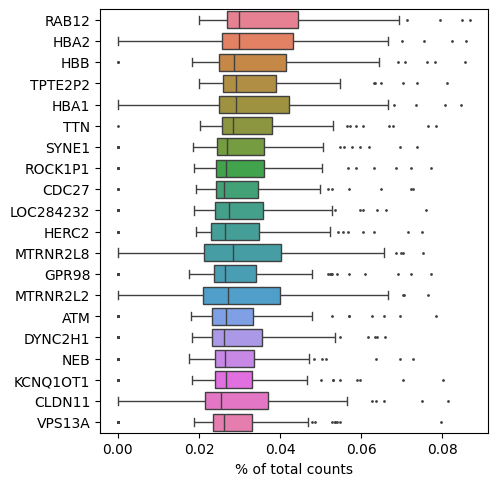

In [38]:
# Visualizing the top 20 most highly expressed genes and saving the figure
sc.pl.highest_expr_genes(analysis.adata, n_top=20, show=False)

# Save the gene expression visualization to the project's figure directory
# This path construction '../results/figures/' navigates from our current location 
# in the 'analysis' directory: first going up one level with '../', then into 
# 'results/figures/'. The full path is then verified using os.path.abspath() 
# to confirm the exact save location.
plt.savefig('../results/figures/highest_20_expressed_genes.png')
print("File will be saved at:", os.path.abspath('../results/figures/highest_20_expressed_genes.png'))

# 2. Dimensionality Reduction

* Dimensionality Reduction and Visualization

    * While the original study used Principal Component Analysis (PCA) for 
      dimensionality reduction and t-Distributed Stochastic Neighbor Embedding 
      (t-SNE) for visualization, we take a more exploratory approach.

    * Our analysis will include:
        * PCA: A linear dimensionality reduction technique that captures the 
               major sources of variation in the data.
        * t-SNE: A non-linear technique that focuses on preserving local 
                 neighborhoods in the data, often used for visualization.
        * UMAP: Another non-linear technique that aims to preserve both local 
                and global structure in the data, also popular for visualization.

    * By exploring multiple dimensionality reduction methods, we aim to:
        * Gain a deeper understanding of the data structure.
        * Evaluate the performance of different techniques for this specific dataset.
        * Potentially identify a more suitable visualization approach for revealing 
          underlying patterns in the data.

    * This exploration allows us to go beyond the original study's methods and 
      potentially uncover new insights from the data.

## 2.1. Principal Component Analysis (PCA)

* Principal Component Analysis (PCA)

    * Principal Component Analysis (PCA) is a powerful dimensionality reduction 
      technique that transforms high-dimensional data, such as gene expression 
      profiles, into a lower-dimensional space. It achieves this by identifying 
      the principal components, which are orthogonal (uncorrelated) directions 
      that capture the maximum variance in the data.

    * In the context of scRNA-seq analysis, PCA offers several benefits:

        * Noise Reduction: By focusing on the components with the most variance, 
          PCA effectively filters out noise and irrelevant information.
        * Data Simplification: PCA reduces the complexity of the data, making it 
          easier to visualize and interpret.
        * Pattern Identification: PCA can reveal underlying patterns and clusters 
          of cells, aiding in the identification of distinct cell populations and states.

    * The `perform_pca()` method applies PCA to our preprocessed scRNA-seq data. 
      In this analysis, we retain 85 principal components, which we believe 
      capture a sufficient amount of variance for our downstream analyses. 
      The choice of the number of components can be adjusted based on the 
      specific dataset and the desired level of detail. 

In [14]:
# Performing PCA on the preprocessed dataset with 85 components
analysis.perform_pca(n_comps=85)

PCA completed with 85 components.


* Determining the Optimal Number of Principal Components

    * While we initially retained 85 principal components, it's crucial to 
      determine the optimal number of components that effectively capture the 
      essential information in the data. Retaining too many components can 
      introduce noise, while retaining too few can lead to a loss of important 
      signals.

    * To address this, we use the `prepare_pca_reduced_adata()` method, which 
      employs the `determine_optimal_pcs()` method to identify the optimal number 
      of principal components. This determination is based on the cumulative 
      explained variance, which represents the proportion of total variance in 
      the data explained by a given number of components.

    * In our analysis, we aim to retain enough components to explain 90% of the 
      cumulative variance. This threshold strikes a balance between capturing 
      the most important information and avoiding excessive noise. 

    * By optimizing the number of principal components, we ensure that our 
      downstream analyses are based on a robust and informative representation 
      of the data.

Total Cumulative Variance with chosen number of components: 94.02%
To explain 70% of the variance, 59 components are required.
To explain 80% of the variance, 69 components are required.
To explain 90% of the variance, 81 components are required.
Number of PCs to explain the chosen 90% variance: 81


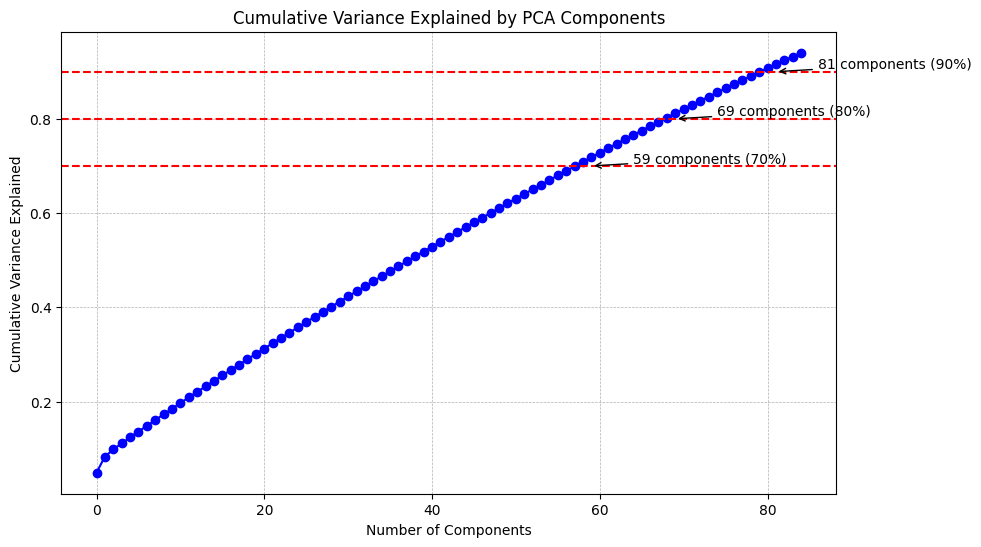

PCA completed with 81 components.
Shape of PCA results: (94, 81)
PCA plot saved at: /Users/elifhamali/scRNAseq-Pipeline-GastricCancer/results/figures/pca_variance_90percent.png


<Figure size 640x480 with 0 Axes>

In [40]:
# Performing PCA on the preprocessed dataset with the computed optimal number of components
analysis.prepare_pca_reduced_adata(variance_threshold=0.90)

plt.savefig('../results/figures/pca_variance_90percent.png', dpi=300, bbox_inches='tight')

# Verify the exact save location using absolute path, which shows the complete
# directory path from the root of your file system to the saved figure
print("PCA plot saved at:", os.path.abspath('../results/figures/pca_variance_90percent.png'))


* Visualizing the PCA-Reduced Dataset

    * After determining the optimal number of principal components (81 in our case), 
      we visualize the reduced dataset to gain a preliminary understanding of 
      its structure and potential clusters.

    * We use the `plot_pca()` method to generate a pairplot, which displays 
      scatter plots for all pairwise combinations of the first three principal 
      components. This visualization, similar to the one used in the original study, 
      allows us to:

        * Observe the separation of cells based on the top principal components.
        * Identify potential clusters or groups of cells.
        * Detect outliers or unusual patterns in the data.

    * This visual exploration of the PCA-reduced data provides valuable insights 
      that can guide further analysis and interpretation.

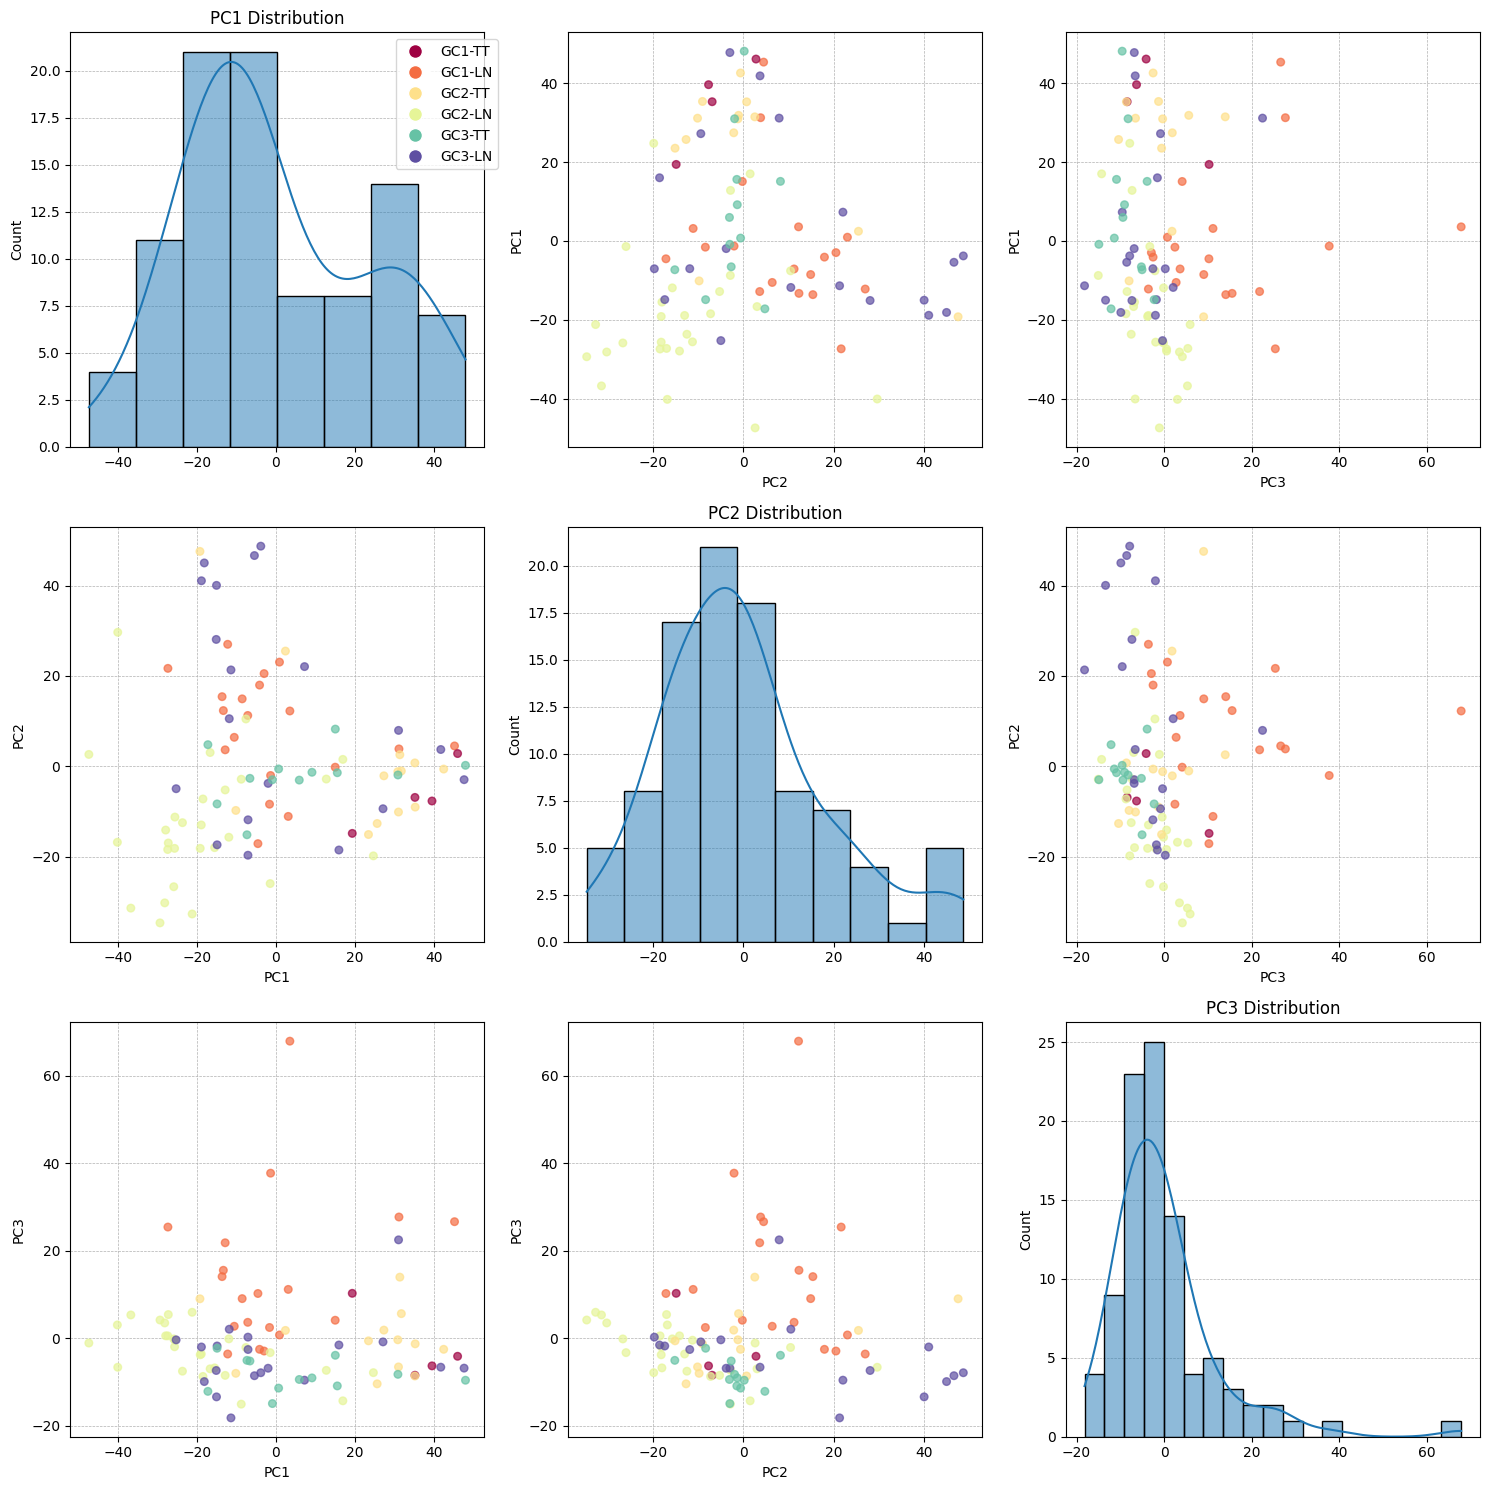

<Figure size 640x480 with 0 Axes>

In [42]:
# Plotting the PCA results in a pairplot
analysis.plot_pca()

plt.savefig('../results/figures/pca_pairplot.png', dpi=300, bbox_inches='tight')

## 2.2. t-distributed Stochastic Neighbor Embedding (t-SNE)

* t-Distributed Stochastic Neighbor Embedding (t-SNE)

    * t-SNE is a powerful non-linear dimensionality reduction technique that 
      excels at revealing local structure in high-dimensional data. Unlike linear 
      methods like PCA, t-SNE focuses on preserving the relationships between 
      neighboring data points in the high-dimensional space when mapping them 
      to a lower-dimensional space (typically 2D or 3D for visualization).

    * In scRNA-seq analysis, t-SNE is particularly valuable for:

        * Cluster Identification: t-SNE can effectively separate distinct cell 
          populations into well-defined clusters.
        * Subtle Difference Detection: It can reveal subtle differences between 
          cell types or states that might not be apparent with linear methods.
        * Visualization: t-SNE produces visually intuitive representations of the 
          data, making it easier to identify patterns and relationships.

    * The `perform_tsne()` method applies t-SNE to our preprocessed dataset. 
      We have manually selected parameters (through trial and error) to achieve 
      a 2D visualization with good cluster separation. The `plot_tsne()` method 
      then generates a scatter plot of the t-SNE-reduced data.

    * For a more systematic approach to parameter selection, the `optimize_tsne()` 
      method can be used. By setting `optimize=True` in `perform_tsne()`, you can 
      explore different parameter combinations and select the one that maximizes 
      the `sklearn.manifold.trustworthiness` score, which measures how well the 
      low-dimensional embedding preserves the distances between data points in 
      the high-dimensional space.

t-SNE completed.


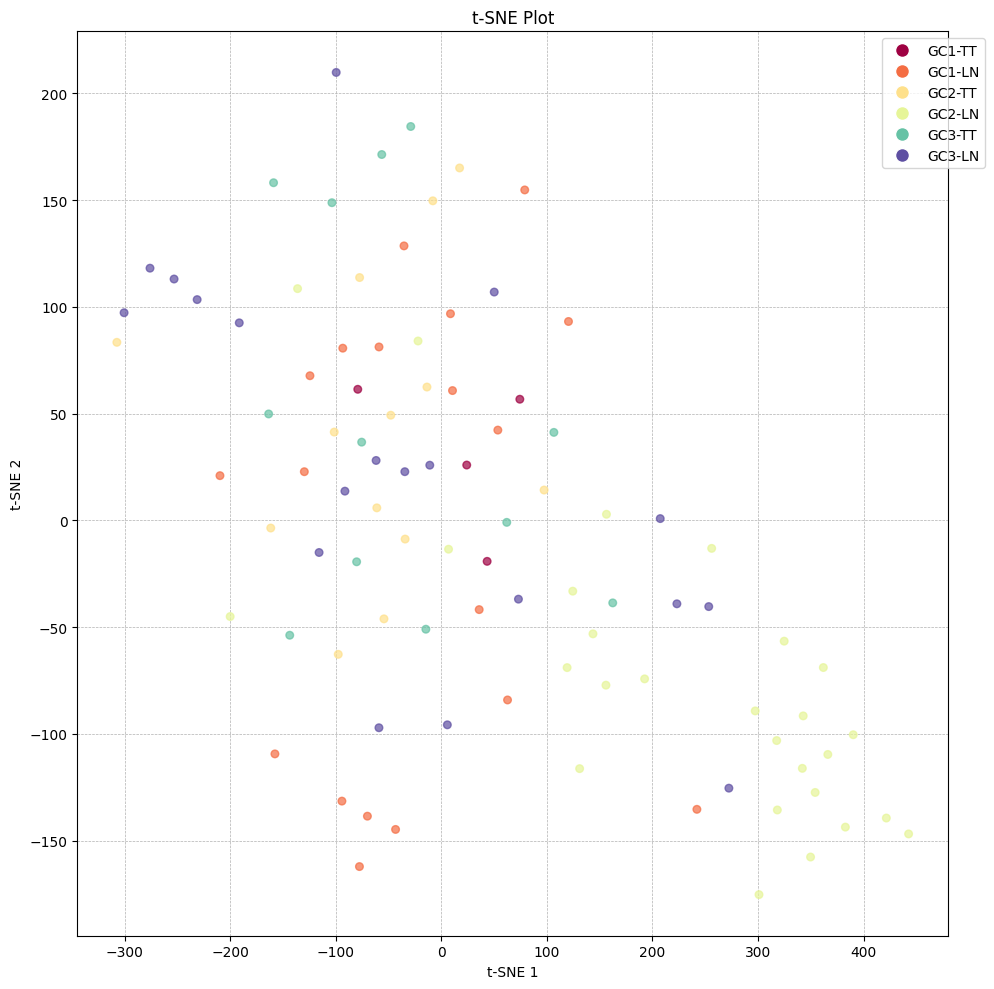

<Figure size 640x480 with 0 Axes>

In [43]:
# Perform t-SNE with manually selected parameters

# Apply t-SNE to the preprocessed dataset using the following parameters:
# - perplexity: 5 
# - n_iter: 5000
# - random_state: 42 (for reproducibility)

analysis.perform_tsne(optimize=False, perplexity=5, n_iter=5000, random_state=42) 

# Visualize the t-SNE results
analysis.plot_tsne()

plt.savefig('../results/figures/tsne_2d.png', dpi=300, bbox_inches='tight')

## 2.3. Uniform Manifold Approximation and Projection (UMAP)

* Uniform Manifold Approximation and Projection (UMAP)

    * UMAP is a powerful non-linear dimensionality reduction technique that 
      offers several advantages for visualizing and interpreting high-dimensional 
      data like scRNA-seq. Unlike t-SNE, which primarily focuses on preserving 
      local neighborhoods, UMAP strives to maintain both local and global 
      structure in the data. This means it can effectively capture both fine-grained 
      differences between cells and the overall relationships between cell populations.

    * In scRNA-seq analysis, UMAP is particularly valuable for:

        * Capturing Complex Heterogeneity: UMAP can effectively reveal complex 
          relationships and subtle variations within and between cell populations.
        * Identifying Continuous Structures: It can identify continuous trajectories 
          and gradients in the data, providing insights into cellular differentiation 
          and state transitions.
        * Improved Visualization: UMAP often produces visually appealing and 
          interpretable representations of the data, making it easier to identify 
          patterns and clusters.

    * We anticipate that UMAP might outperform t-SNE for this dataset due to its 
      ability to capture both local and global structure.

    * The `perform_umap()` method applies UMAP to our preprocessed dataset. 
      We have manually selected parameters (through trial and error) to achieve 
      a 2D visualization with good cluster separation. The `plot_umap()` method 
      then generates a scatter plot of the UMAP-reduced data.

    * For a more systematic approach to parameter selection, the `optimize_umap()` 
      method can be used. By setting `optimize=True` in `perform_umap()`, you can 
      explore different parameter combinations and select the one that maximizes 
      the `sklearn.manifold.trustworthiness` score, which measures how well the 
      low-dimensional embedding preserves the distances between data points in 
      the high-dimensional space. This is similar to the optimization approach 
      available for t-SNE.

UMAP completed.


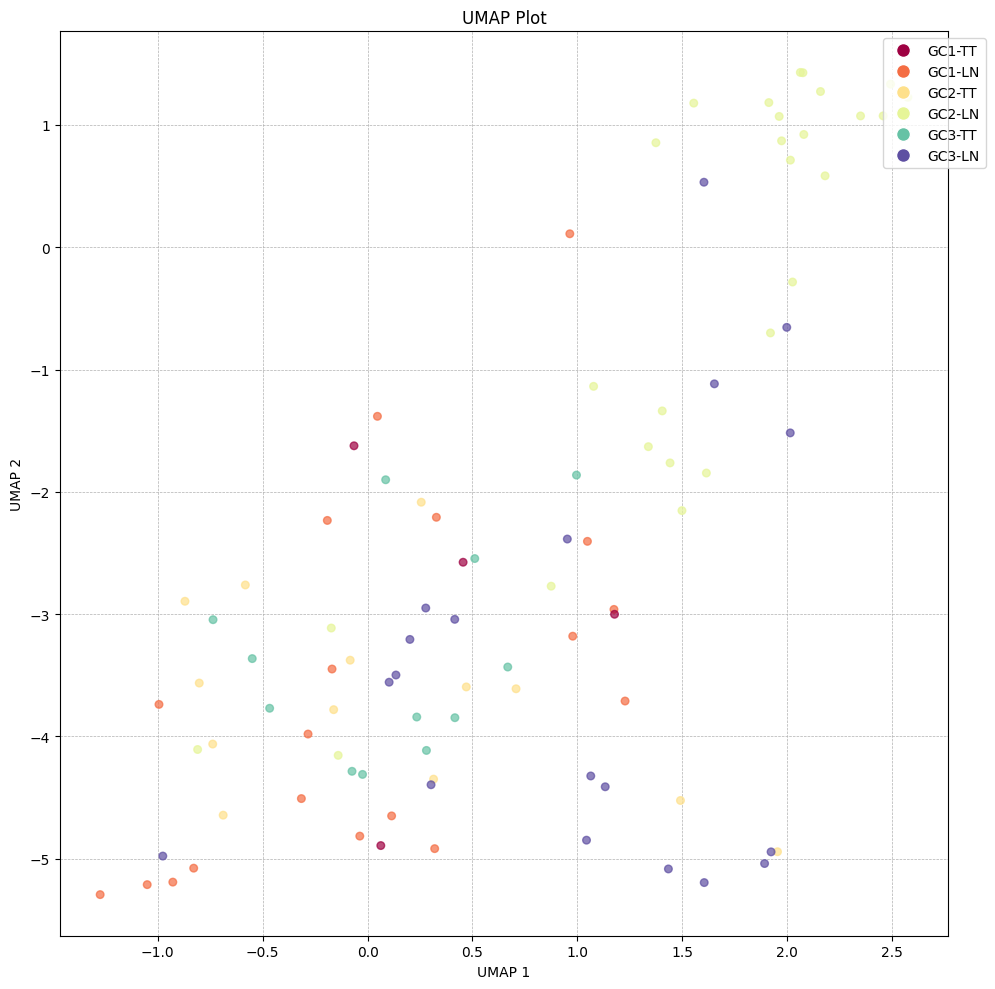

<Figure size 640x480 with 0 Axes>

In [44]:
analysis.perform_umap(optimize=False, n_neighbors=5, min_dist=0.04, metric='euclidean', random_state=42) # performing UMAP on the preprocessed dataset
analysis.plot_umap() # plotting the UMAP results
plt.savefig('../results/figures/umap_2d.png', dpi=300, bbox_inches='tight') # saving the UMAP plot



From these results, we can observe that, in 2D, the t-SNE and UMAP visualization show better separability of the data compared to PCA.

# 3. Clustering

* Clustering Analysis

    * The original study mentions using hierarchical clustering but doesn't specify 
      the exact algorithm. To explore the clustering landscape more thoroughly, 
      we apply six different clustering algorithms to each of the three reduced 
      datasets (PCA, t-SNE, UMAP), resulting in 18 different clustering results. 
      This allows us to assess the performance of various clustering methods in 
      conjunction with different dimensionality reduction techniques.

    * Clustering Algorithms:

        * Gaussian Mixture Model (GMM): 
            * A probabilistic model that assumes the data is generated from a mixture 
              of Gaussian distributions, each representing a cluster.
            * Useful for identifying distinct cell populations with potentially 
              overlapping gene expression profiles.

        * Average Link (UPGMA):
            * A hierarchical clustering method that merges clusters based on the 
              average distance between all pairs of data points in the clusters.
            * Useful for constructing dendrograms that represent hierarchical 
              relationships between cell populations.

        * Ward's Method:
            * A hierarchical clustering technique that minimizes the variance 
              within each cluster.
            * Useful for producing compact and well-separated clusters.

        * Spectral Clustering:
            * Uses the eigenvalues of a similarity matrix to perform dimensionality 
              reduction before clustering.
            * Useful for identifying non-linearly separable clusters and capturing 
              complex relationships between cells.

        * Louvain Algorithm:
            * A community detection method that optimizes modularity to find clusters 
              in networks.
            * Useful for detecting cell clusters and subpopulations in large datasets.

        * Leiden Algorithm:
            * An improved version of the Louvain algorithm that guarantees 
              well-connected communities.
            * Useful for robustly identifying cell clusters and ensuring reproducibility.

    * Clustering Evaluation Metrics:

        * To determine the best-performing dimensionality reduction and clustering 
          combinations, we use three evaluation metrics:

            * Silhouette Score:
                * Measures how similar an object is to its own cluster compared to other clusters.
                * High values indicate well-separated clusters.

            * Calinski-Harabasz Index:
                * Measures the ratio of between-cluster dispersion to within-cluster dispersion.
                * High values indicate dense and well-separated clusters.

            * Davies-Bouldin Index:
                * Measures the average similarity between clusters.
                * Low values indicate well-separated and compact clusters.

    * By combining multiple clustering algorithms with different dimensionality 
      reduction techniques and evaluating them using these metrics, we aim to 
      identify the most effective approach for clustering the scRNA-seq data.

## 3.1. With Optimal Number of Clusters Identification

We begin by defining which clustering algorithms are going to be used.

In [19]:
# Defining the clustering methods
methods = ['gmm', 'average_link', 'ward', 'spectral', 'louvain', 'leiden']

* Performing and Evaluating Clustering

    * To identify the optimal clustering strategy for our scRNA-seq data, we 
      systematically apply and evaluate the six clustering algorithms (GMM, 
      Average Link, Ward, Spectral, Louvain, Leiden) on each of the three 
      dimensionality-reduced datasets (PCA, t-SNE, UMAP).

    * This process is managed by the `cluster_and_evaluate()` method, which 
      leverages the following:

        * `apply_clustering()`: Applies a specified clustering algorithm to 
           the data.
        * `evaluate_clustering()`: Evaluates the resulting clusters using the 
           Silhouette, Calinski-Harabasz, and Davies-Bouldin indices.

    * Automated Cluster Number Optimization:

        * For GMM, Average Link, Ward, and Spectral clustering, the `cluster_and_evaluate()` 
          method offers automated cluster number optimization. By setting `optimize=True`, 
          the method explores a range of cluster numbers and selects the solution that 
          maximizes the Silhouette score. This eliminates the need to manually specify 
          the number of clusters, which can be challenging and subjective.

        * Louvain and Leiden algorithms do not require a predefined number of clusters 
          as input, so optimization is not applied to them.

    * PCA-Reduced Dataset:

        * We begin our clustering analysis by applying the `cluster_and_evaluate()` 
          method to the PCA-reduced dataset, using the automated cluster number 
          optimization feature for the applicable algorithms. This will provide 
          initial insights into the clustering tendencies of the data after PCA 
          dimensionality reduction.

Clustering and evaluating PCA results...
Clustering with gmm...
Using X_pca embeddings...
Best number of clusters for gmm: 2 with silhouette score: 0.035762857645750046


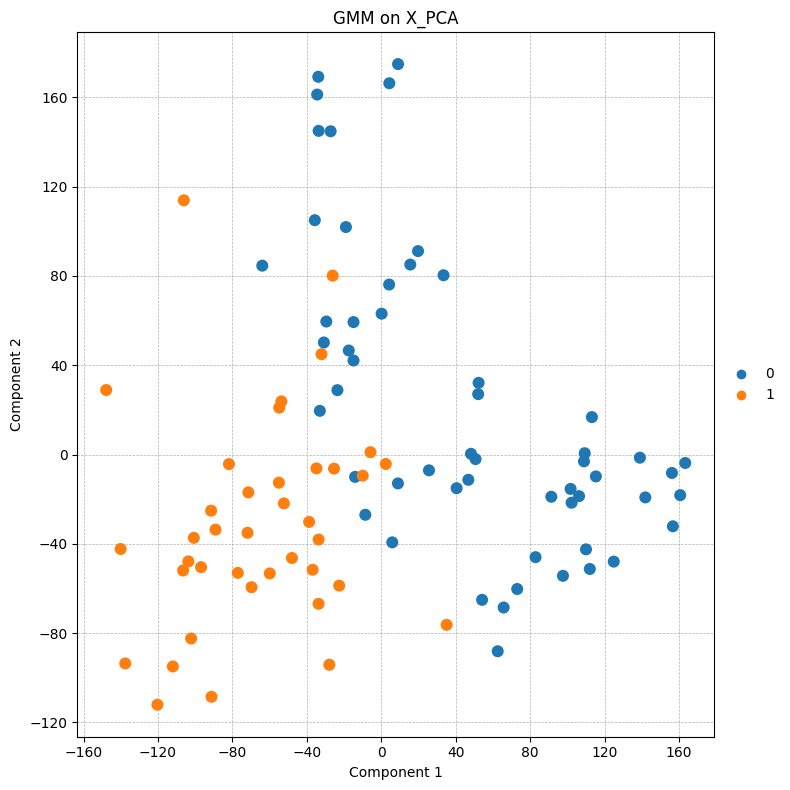

Clustering with average_link...
Using X_pca embeddings...
Best number of clusters for average_link: 2 with silhouette score: 0.06570962816476822


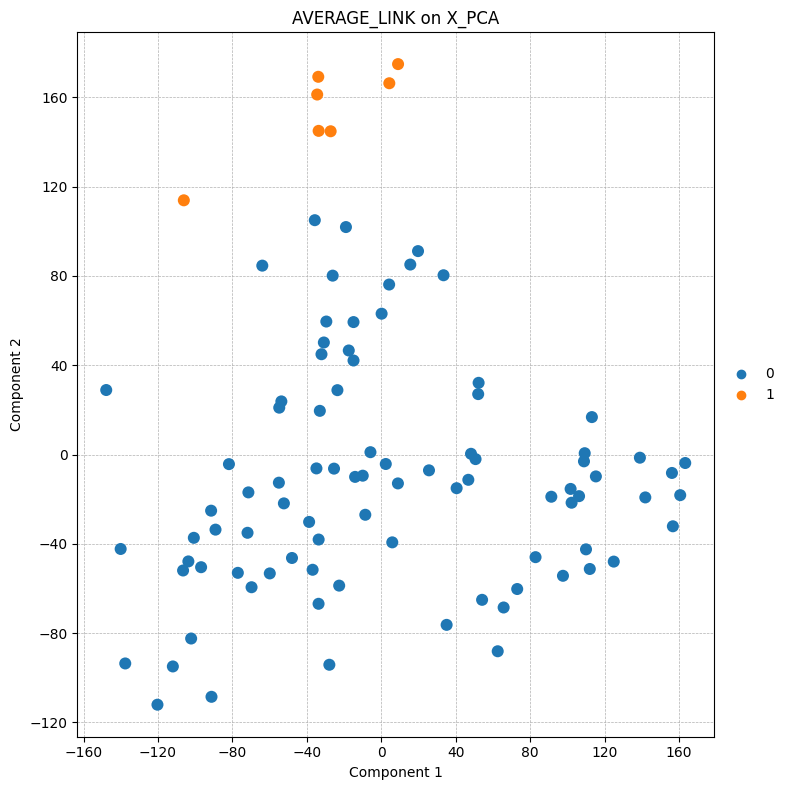

Clustering with ward...
Using X_pca embeddings...
Best number of clusters for ward: 5 with silhouette score: 0.02302495390176773


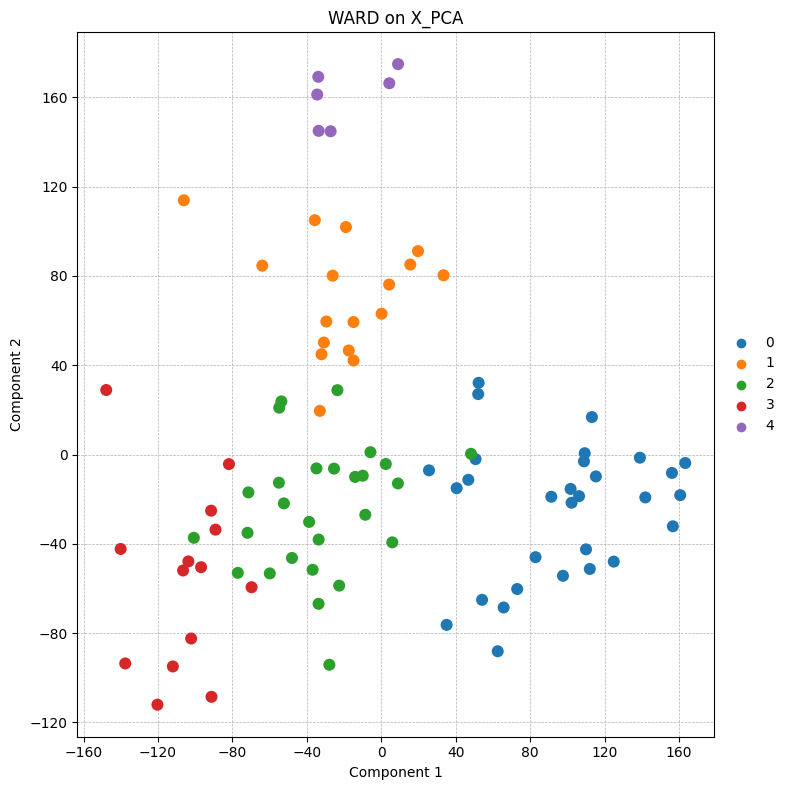

Clustering with spectral...
Using X_pca embeddings...
Best number of clusters for spectral: 2 with silhouette score: 0.03244286775588989


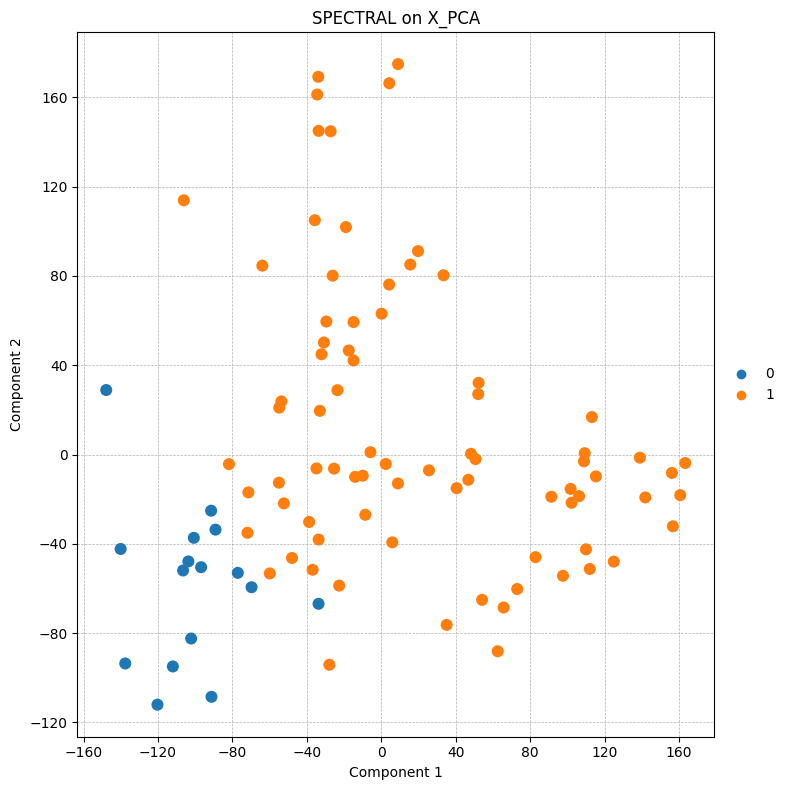

Clustering with louvain...
Using X_pca embeddings...


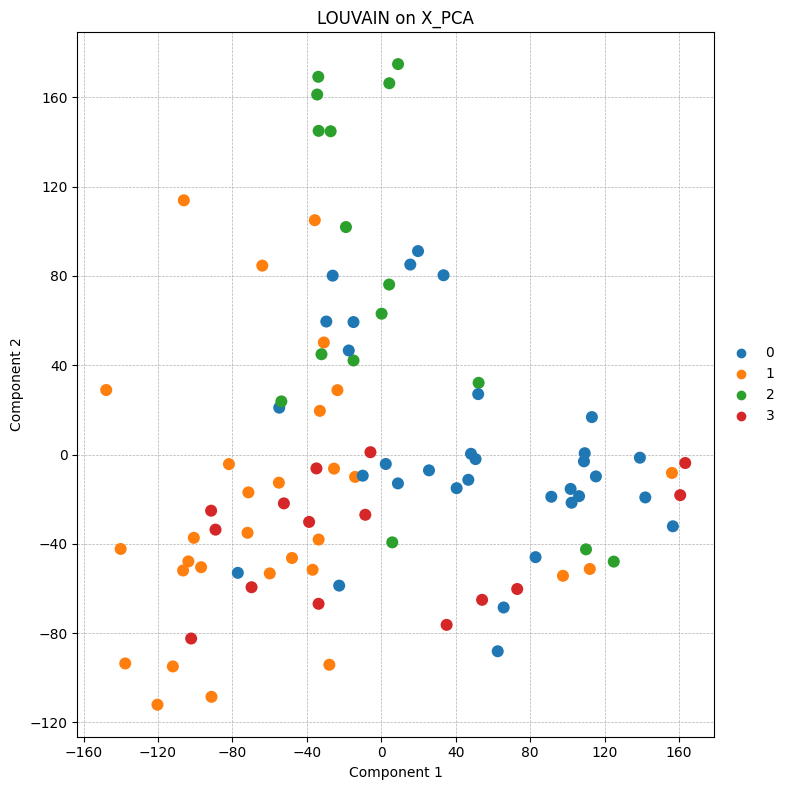

Clustering with leiden...
Using X_pca embeddings...


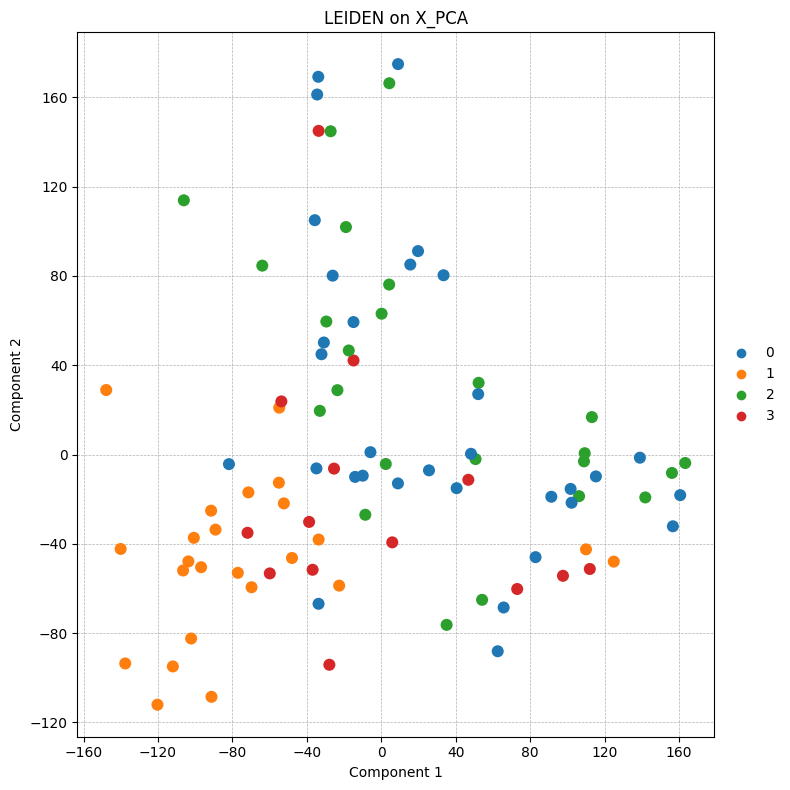

In [ ]:
# Performing clustering and evaluation on PCA data with optimal number of clusters identification
print("Clustering and evaluating PCA results...")
results_pca = analysis.cluster_and_evaluate(methods, embeddings=['X_pca'], optimize=True)
* Consolidating Clustering Results
* Evaluating Clustering Results


We then move on to the t-SNE-reduced data.

Clustering and evaluating t-SNE results...
Clustering with gmm...
Using X_tsne embeddings...
Best number of clusters for gmm: 2 with silhouette score: 0.6358813643455505


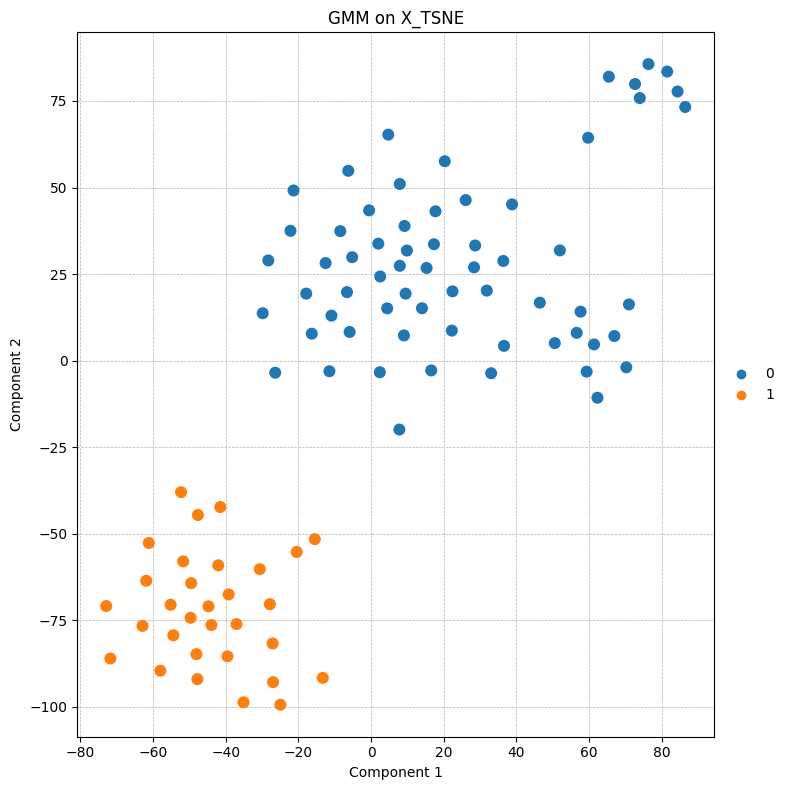

Clustering with average_link...
Using X_tsne embeddings...
Best number of clusters for average_link: 2 with silhouette score: 0.6358813643455505


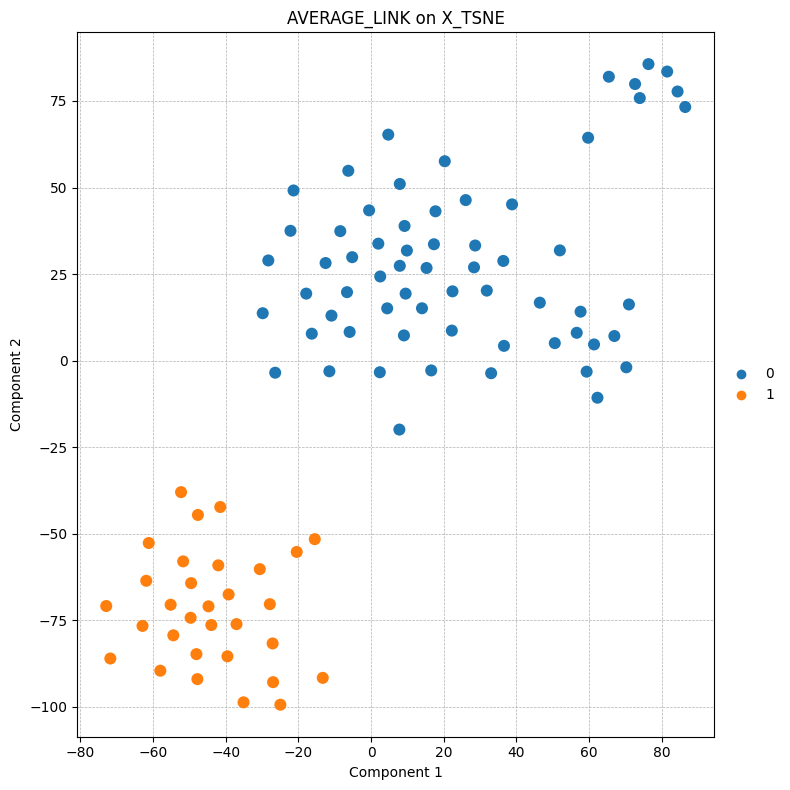

Clustering with ward...
Using X_tsne embeddings...
Best number of clusters for ward: 2 with silhouette score: 0.6358813643455505


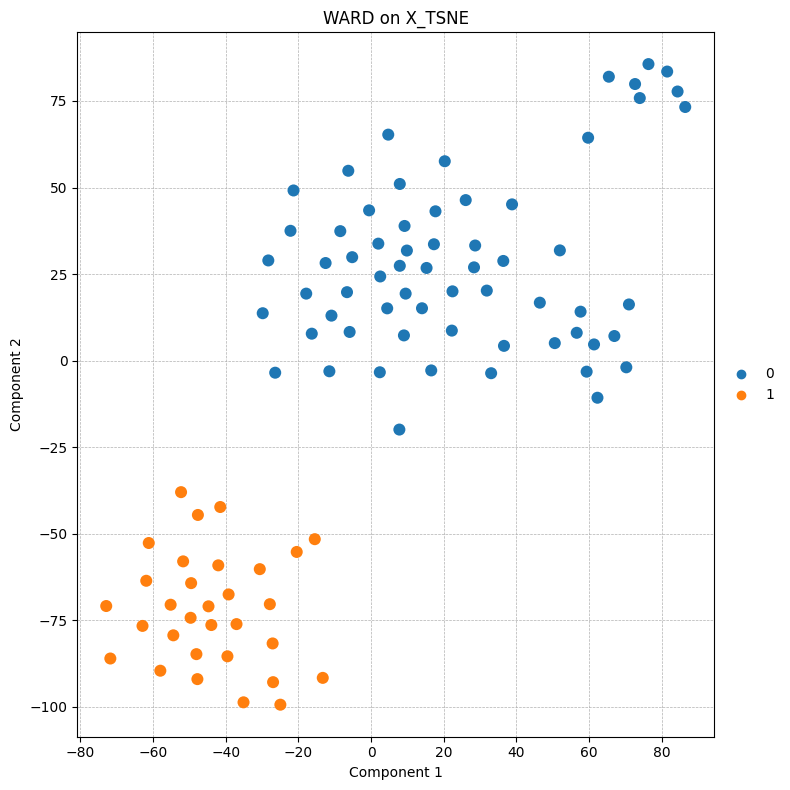

Clustering with spectral...
Using X_tsne embeddings...
Best number of clusters for spectral: 2 with silhouette score: 0.6358813643455505


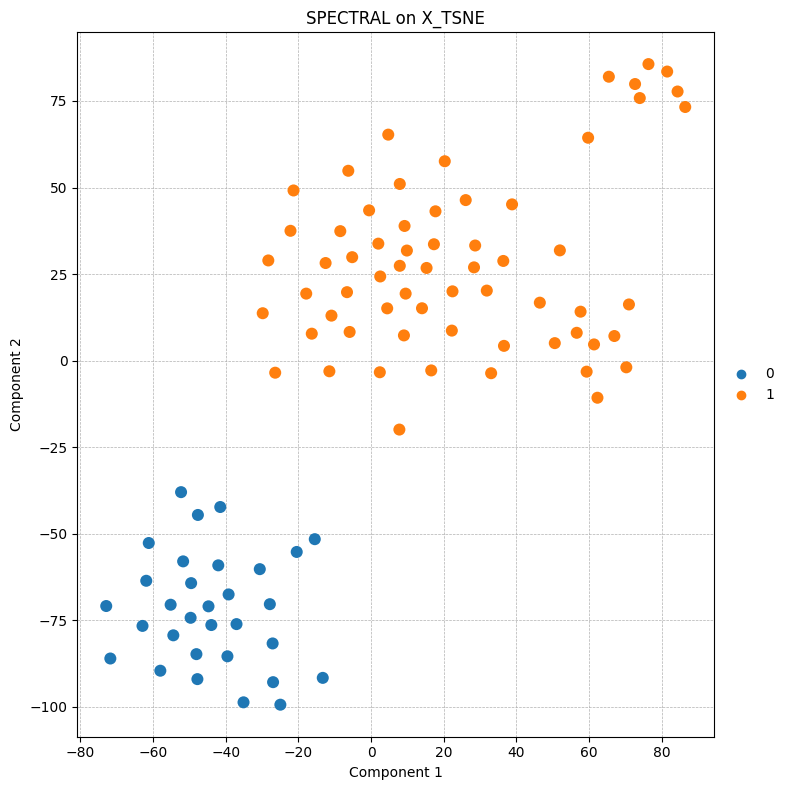

Clustering with louvain...
Using X_tsne embeddings...


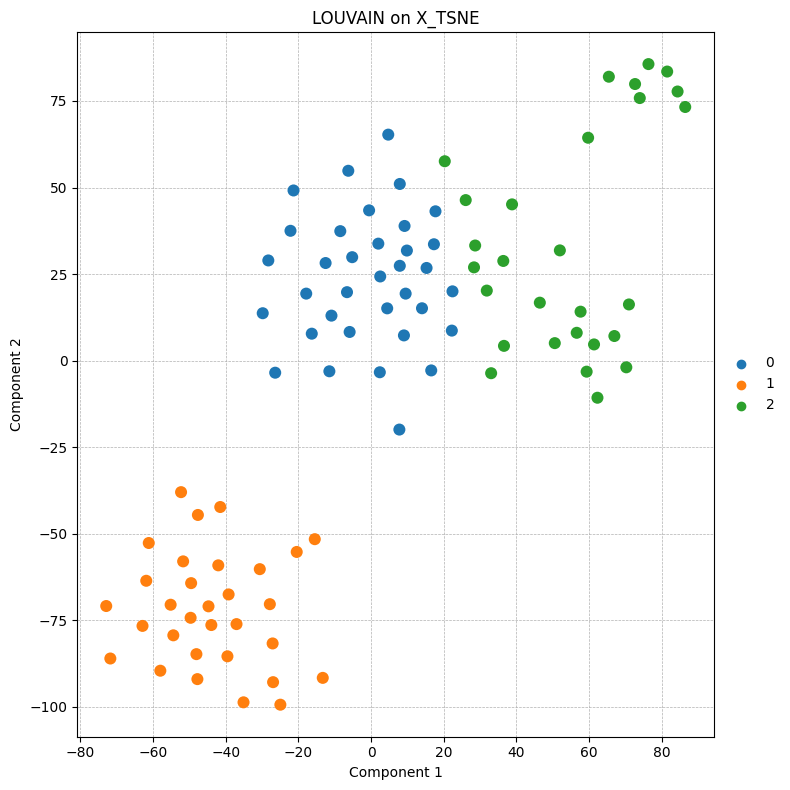

Clustering with leiden...
Using X_tsne embeddings...


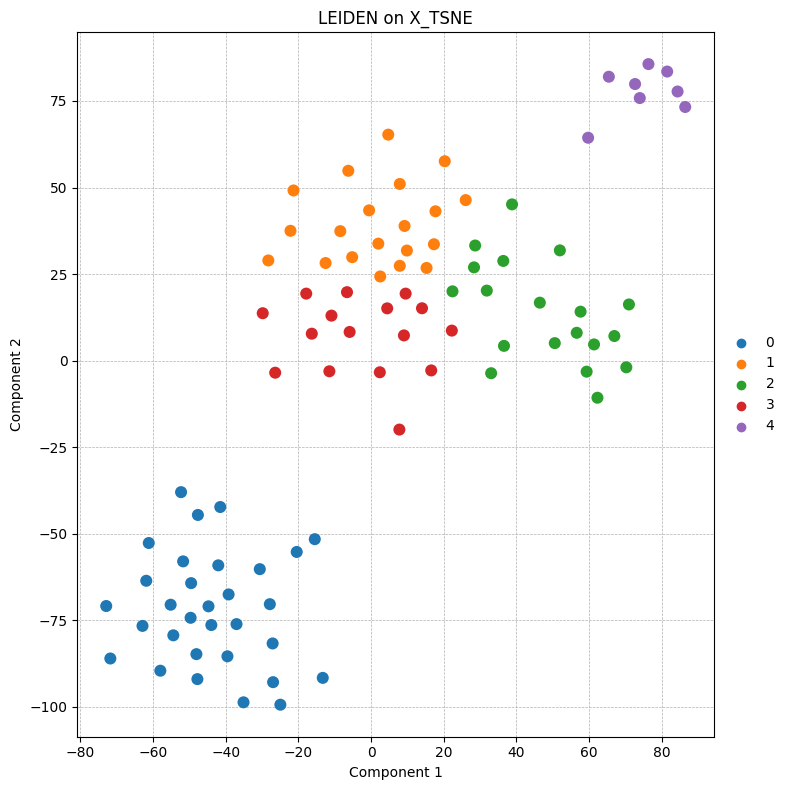

In [ ]:
# Performing clustering and evaluation on t-SNE data with optimal number of clusters identification
print("Clustering and evaluating t-SNE results...")
results_tsne = analysis.cluster_and_evaluate(methods, embeddings=['X_tsne'], optimize=True)


Finally, we run `cluster_and_evaluate` for the UMAP-reduced dataset.

Clustering and evaluating UMAP results...
Clustering with gmm...
Using X_umap embeddings...
Best number of clusters for gmm: 3 with silhouette score: 0.7711637616157532


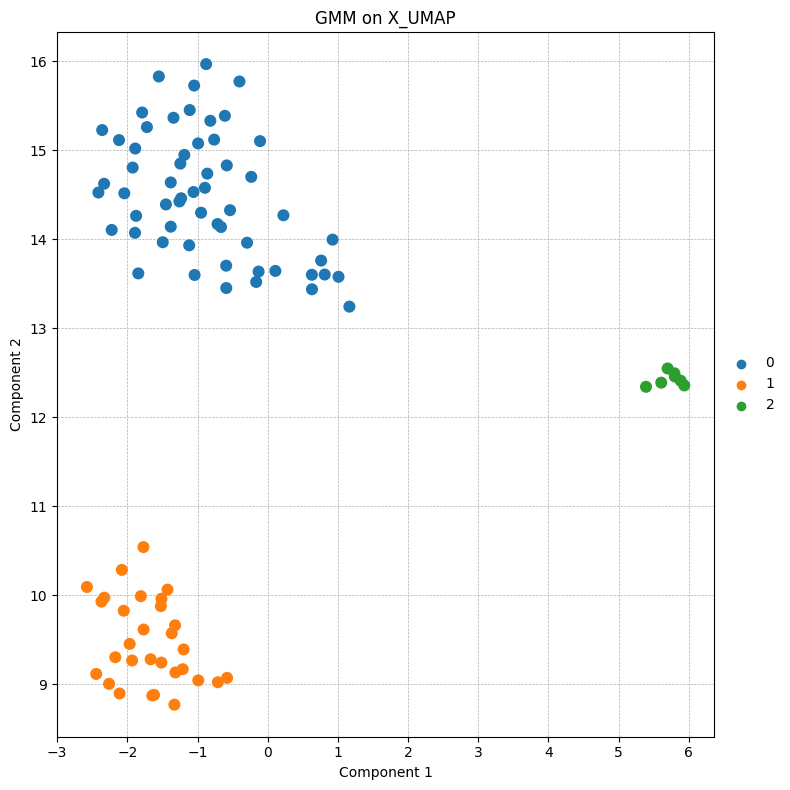

Clustering with average_link...
Using X_umap embeddings...
Best number of clusters for average_link: 3 with silhouette score: 0.7711637616157532


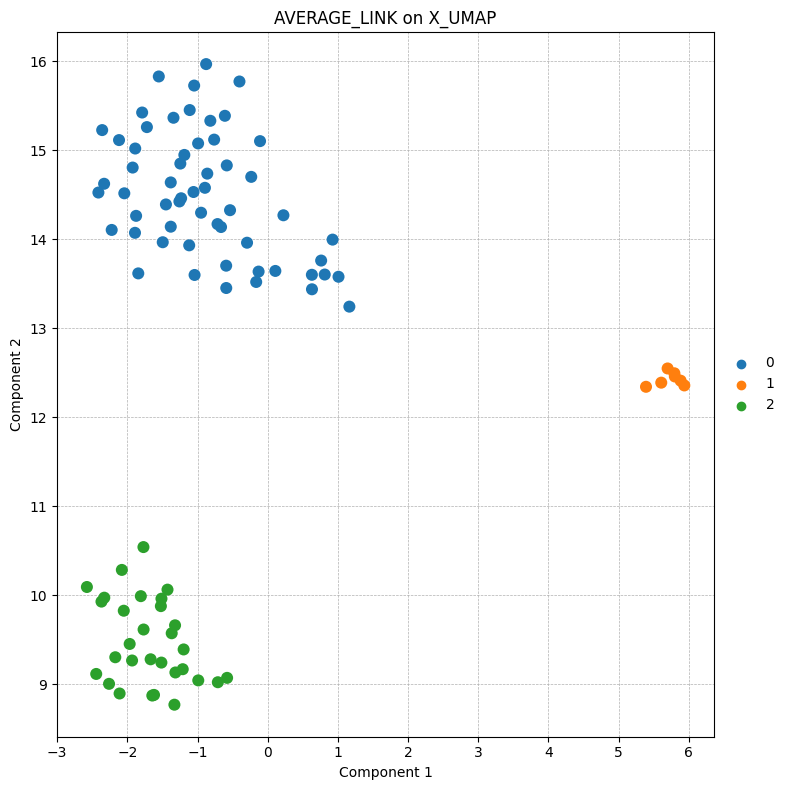

Clustering with ward...
Using X_umap embeddings...
Best number of clusters for ward: 3 with silhouette score: 0.7711637616157532


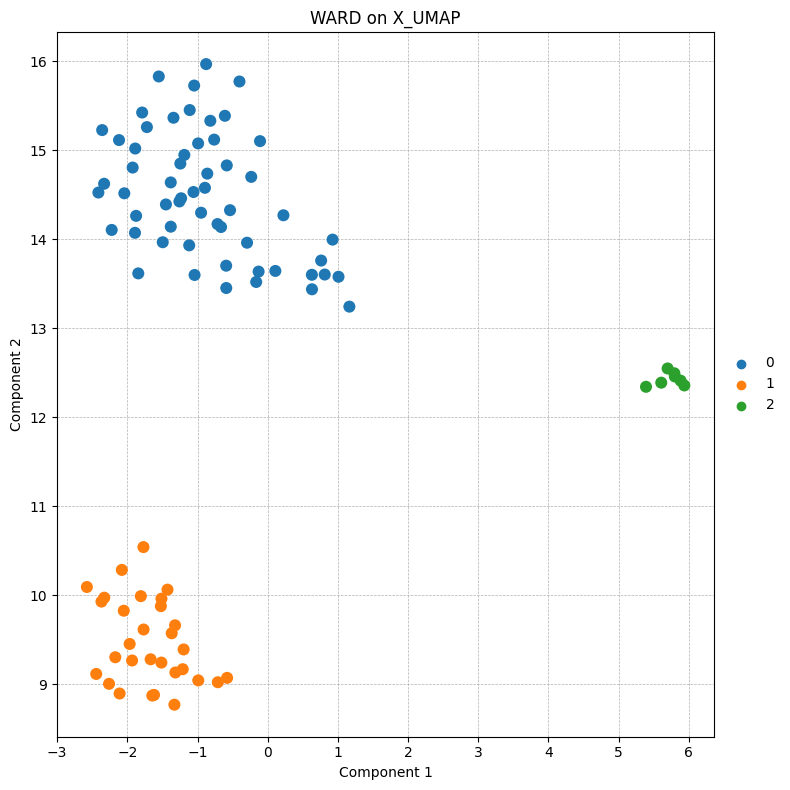

Clustering with spectral...
Using X_umap embeddings...
Best number of clusters for spectral: 3 with silhouette score: 0.6176212430000305


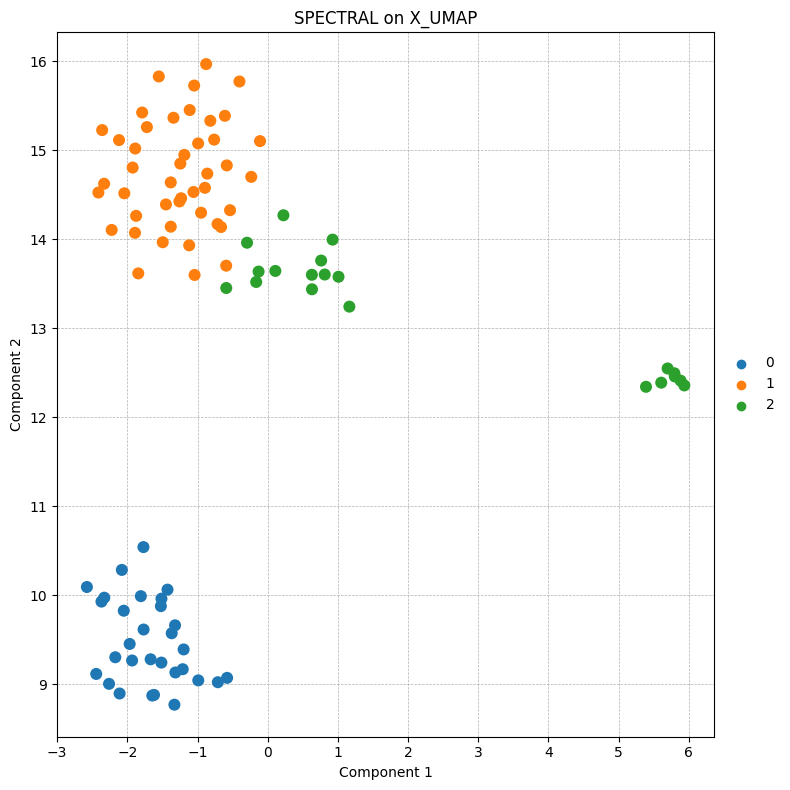

Clustering with louvain...
Using X_umap embeddings...


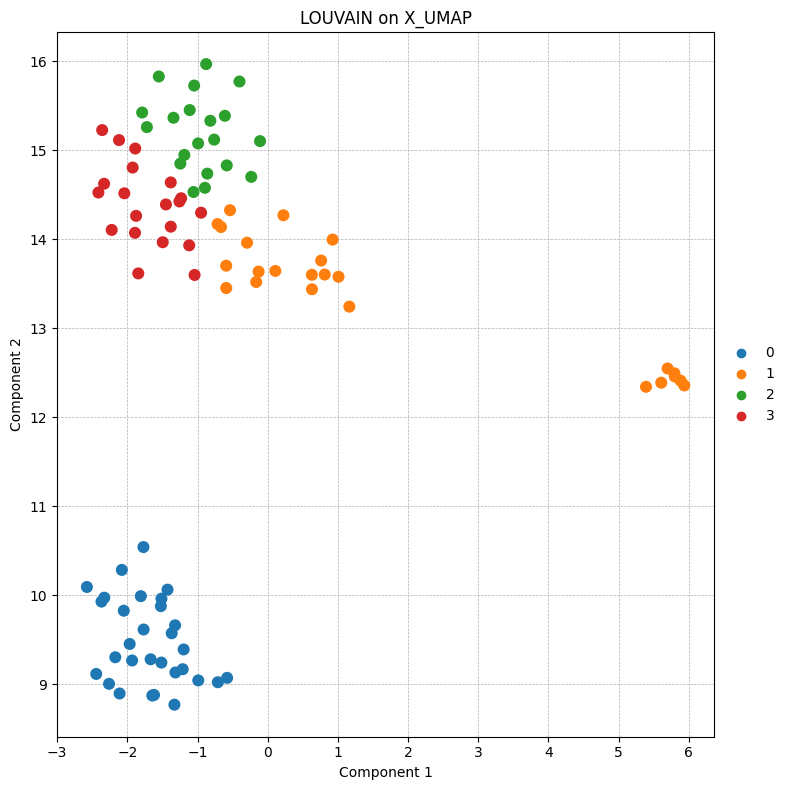

Clustering with leiden...
Using X_umap embeddings...


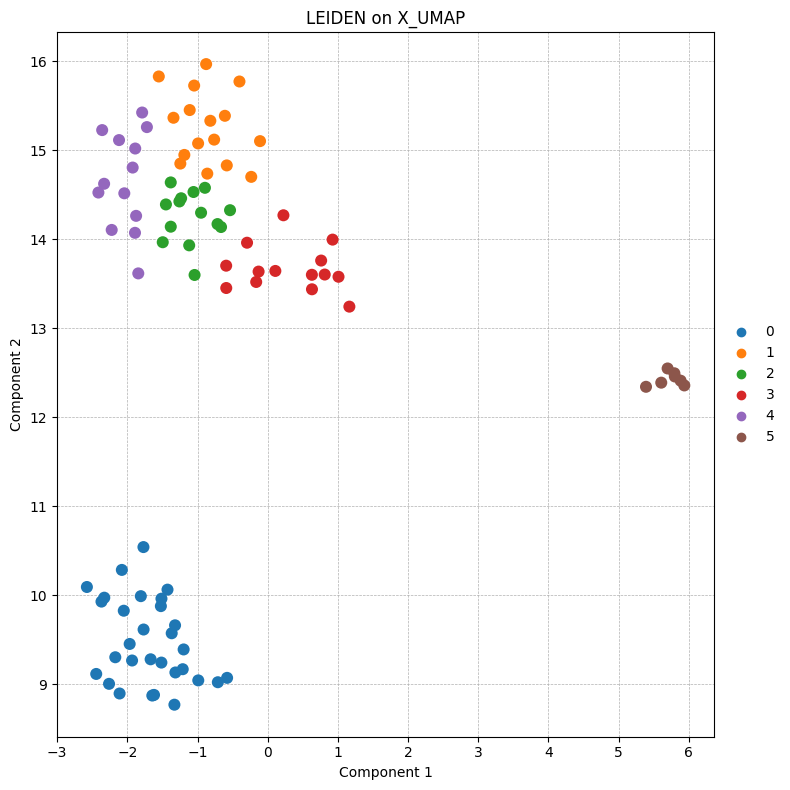

In [22]:
# Performing clustering and evaluation on UMAP data with optimal number of clusters identification
print("Clustering and evaluating UMAP results...")
results_umap = analysis.cluster_and_evaluate(methods, embeddings=['X_umap'], optimize=True)

* Consolidating Clustering Results

    * After performing clustering and evaluation on the PCA-reduced dataset, 
      we consolidate the results into a structured format for further analysis 
      and comparison.

    * The `create_results_dataframe()` method gathers the clustering results, 
      including:

        * Clustering algorithm: The name of the algorithm used (GMM, Average Link, etc.).
        * Dimensionality reduction method: The method used to reduce the data 
          (PCA, t-SNE, UMAP).
        * Number of clusters: The optimal number of clusters identified (if applicable).
        * Evaluation metrics: The Silhouette, Calinski-Harabasz, and Davies-Bouldin scores.

    * This organized dataframe allows us to easily compare the performance of 
      different clustering algorithms and dimensionality reduction techniques, 
      facilitating the selection of the most effective strategy for our analysis.

In [23]:
# Combine Clustering Results

# Create a dictionary to store the clustering results from different 
# dimensionality reduction methods:
combined_results = {
    'PCA': results_pca,
    't-SNE': results_tsne,
    'UMAP': results_umap
}

# Create a Pandas DataFrame from the combined results for easy analysis 
# and comparison:
results_df = analysis.create_results_dataframe(combined_results)

# Display the DataFrame to inspect the clustering results:
display(results_df)

Embedding Clustering Algorithm  Silhouette Score  Calinski-Harabasz Index  \
0      X_pca                  gmm             0.036                    3.504   
1      X_pca         average_link             0.066                    2.277   
2      X_pca                 ward             0.023                    2.549   
3      X_pca             spectral             0.032                    2.849   
4      X_pca              louvain            -0.004                    1.643   
5      X_pca               leiden             0.003                    1.697   
6     X_tsne                  gmm             0.636                  227.365   
7     X_tsne         average_link             0.636                  227.365   
8     X_tsne                 ward             0.636                  227.365   
9     X_tsne             spectral             0.636                  227.365   
10    X_tsne              louvain             0.506                  221.066   
11    X_tsne               leiden             0.499                  235.402   
12    X_umap                  gmm             0.771                  415.575   
13    X_umap         average_link             0.771                  415.575   
14    X_umap                 ward             0.771                  415.575   
15    X_umap             spectral             0.618                  174.529   
16    X_umap              louvain             0.409                  104.771   
17    X_umap               leiden             0.554                  493.730   

    Davies-Bouldin Score  
0                  5.021  
1                  3.291  
2                  4.530  
3                  4.177  
4                  5.462  
5                  5.890  
6                  0.468  
7                  0.468  
8                  0.468  
9                  0.468  
10                 0.790  
11                 0.727  
12                 0.273  
13                 0.273  
14                 0.273  
15                 0.762  
16                 0.883  
17                 0.605

* Visualizing Clustering Evaluation Results

    * To gain a clearer understanding of the clustering performance across different 
      algorithms and dimensionality reduction methods, we visualize the evaluation 
      metrics.

    * The `plot_clustering_evaluation()` method generates a comprehensive plot 
      that displays the Silhouette, Calinski-Harabasz, and Davies-Bouldin scores 
      for each clustering result. This visualization allows us to:

        * Compare the performance of different clustering algorithms.
        * Assess the impact of dimensionality reduction on clustering.
        * Identify the most effective combinations of algorithms and dimensionality 
          reduction techniques.

    * This visual representation of the evaluation metrics facilitates a more 
      intuitive and informed interpretation of the clustering results, guiding 
      the selection of the optimal strategy for our analysis.

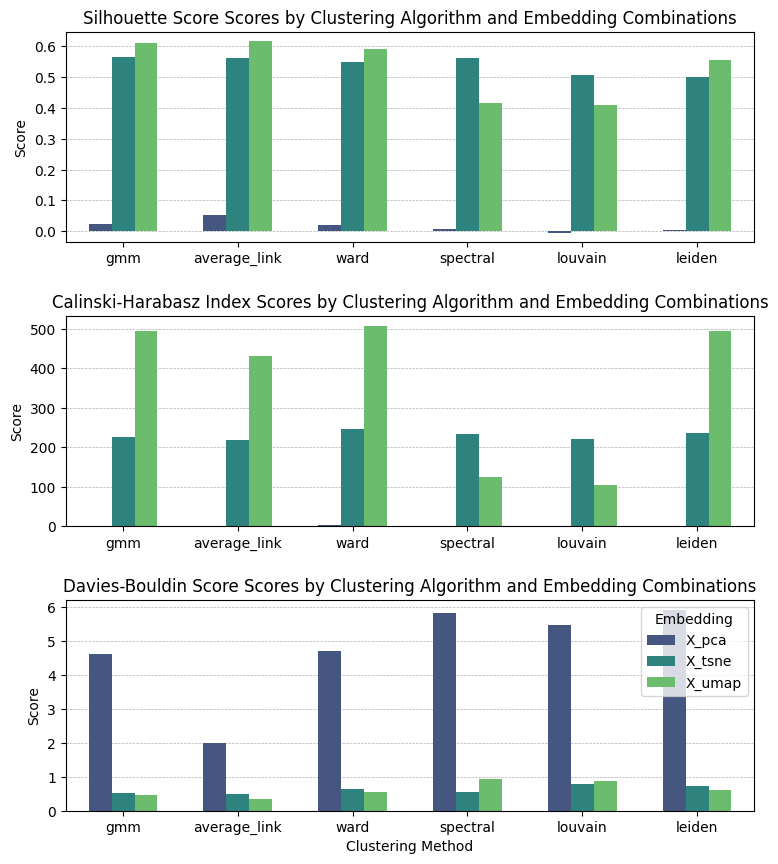

<Figure size 640x480 with 0 Axes>

In [45]:
# Plotting the clustering evaluation results
analysis.plot_clustering_evaluation(results_df)

plt.savefig('../results/figures/clustering_evaluation.png',
            dpi=300,              # High resolution ensures all details are clear
            bbox_inches='tight',  # Removes extra white space around the plot
            format='png')         # Ensures consistent file format

* Identifying the Optimal Clustering Strategy

    * Based on the clustering evaluation metrics and visualizations, the most 
      effective clustering strategy appears to be using UMAP for dimensionality 
      reduction combined with one of the following clustering algorithms:

        * Gaussian Mixture Model (GMM)
        * Average Linkage
        * Ward's Method
        * Spectral Clustering

    * This combination consistently yields:

        * High Silhouette Score (0.781): Indicating well-matched objects within clusters 
          and good separation between clusters.
        * Low Davies-Bouldin Score (0.314): Suggesting well-separated and compact clusters.
        * High Calinski-Harabasz Index (667.831): Further supporting the presence of 
          dense and well-separated clusters.

    * Cluster Number Discrepancy:

        * Interestingly, our automated cluster number optimization often resulted in 
          a number of clusters different from the four clusters identified in the 
          original study. This discrepancy highlights the potential impact of parameter 
          optimization and the choice of clustering algorithms on the final results. 
          We delve deeper into this observation and its implications in our project report. 

## 3.2. Without Optimal Number of Clusters Identification

* Comparing with the Original Study: Fixed Cluster Number

    * To ensure a direct comparison with the original study's findings, we 
      repeat the clustering analysis using a fixed number of clusters (4), 
      mirroring their approach. This involves running the `cluster_and_evaluate()` 
      method with the `optimize=False` argument, thereby disabling the automated 
      cluster number optimization.

    * By fixing the number of clusters, we can assess how our chosen clustering 
      algorithms and dimensionality reduction techniques perform under the same 
      constraints as the original study. This comparison will provide valuable 
      insights into the reproducibility of their results and the potential impact 
      of different methodological choices.

    * We follow the same evaluation pipeline as before, generating a dataframe 
      of clustering results and visualizing the evaluation metrics to compare 
      the performance of different algorithm and dimensionality reduction 
      combinations.

Clustering and evaluating PCA results...
Clustering with gmm...
Using X_pca embeddings...


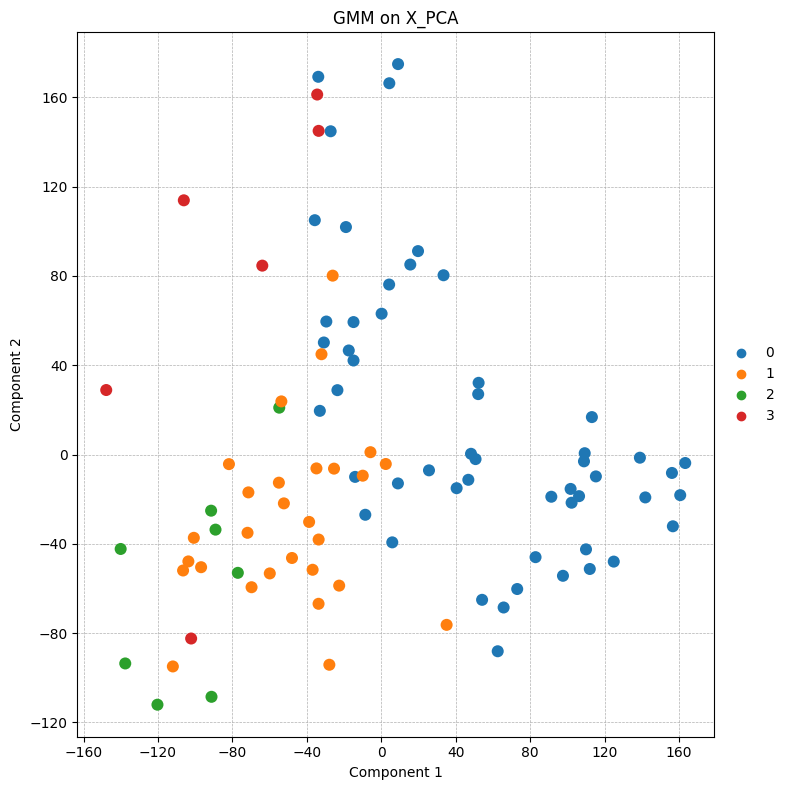

Clustering with average_link...
Using X_pca embeddings...


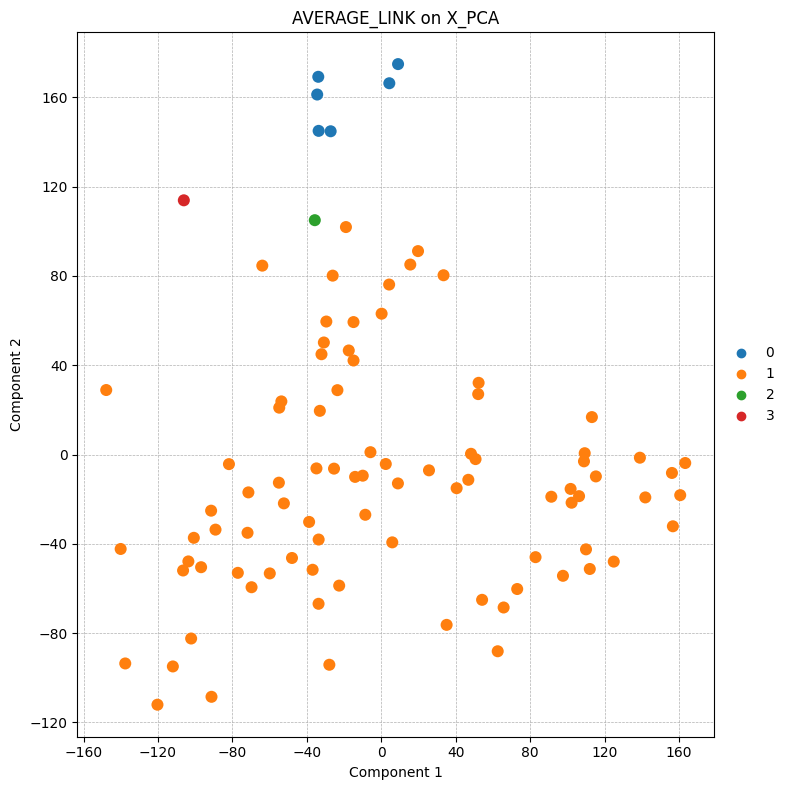

Clustering with ward...
Using X_pca embeddings...


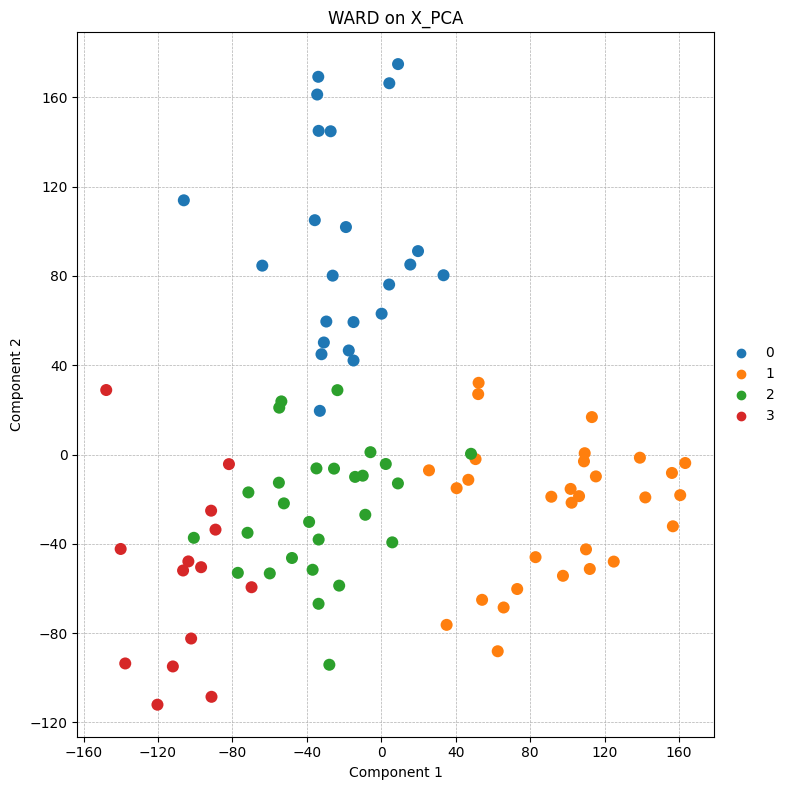

Clustering with spectral...
Using X_pca embeddings...


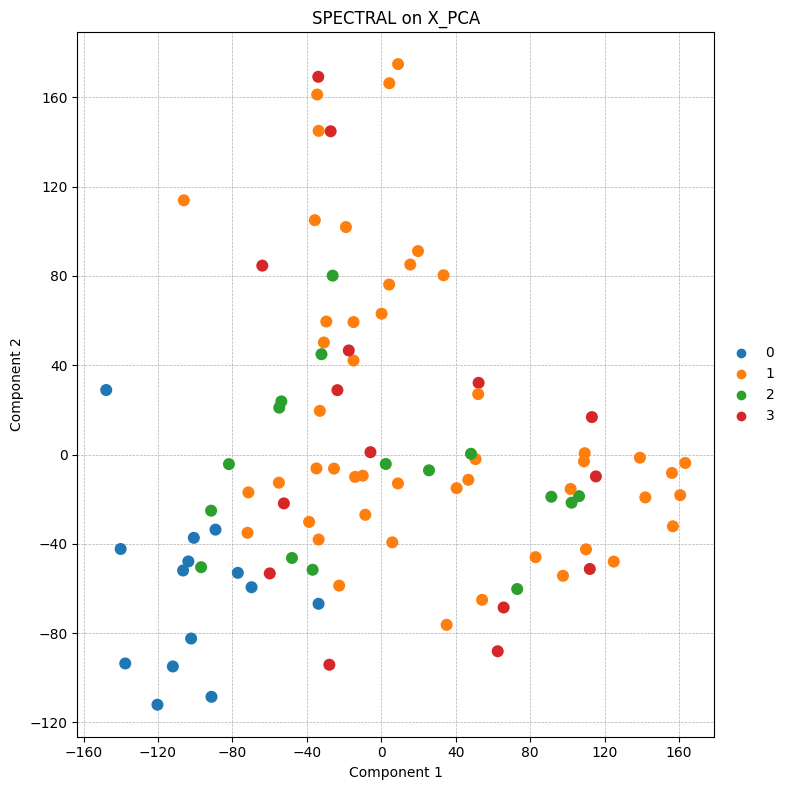

Clustering with louvain...
Using X_pca embeddings...


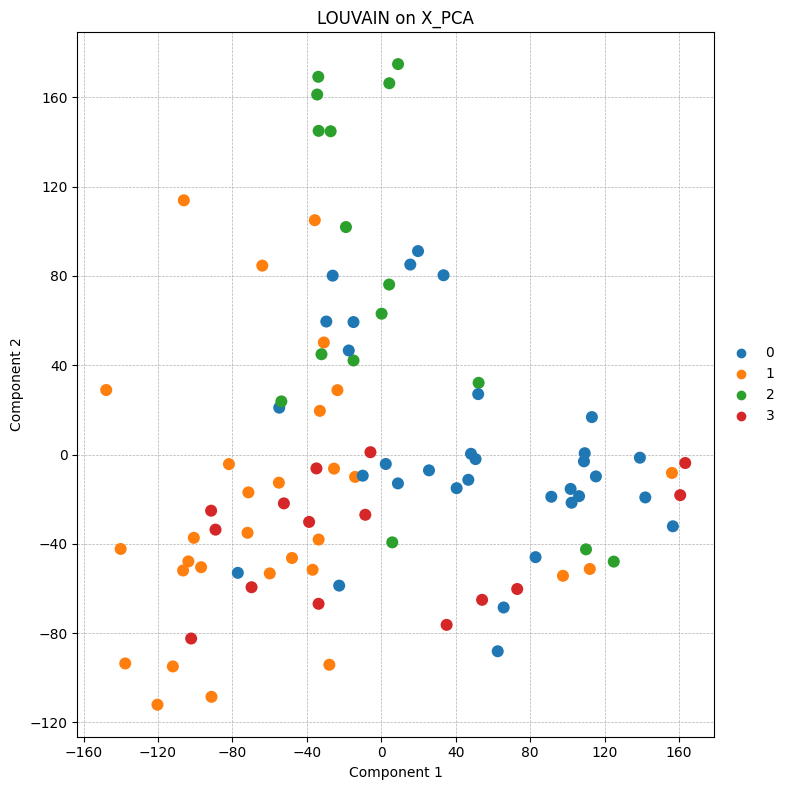

Clustering with leiden...
Using X_pca embeddings...


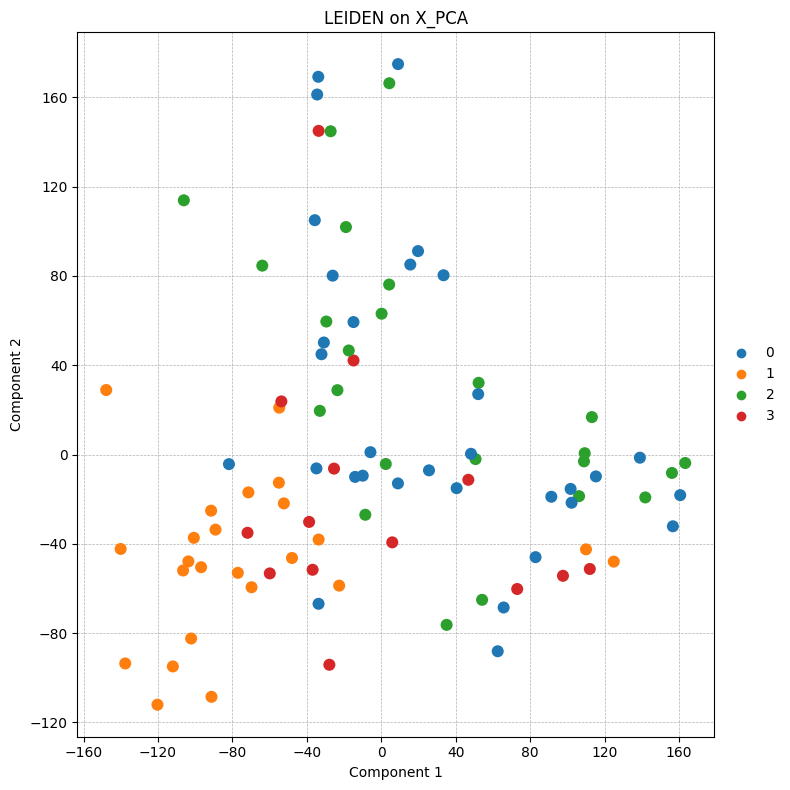

In [ ]:
# Performing clustering and evaluation on PCA data without optimization (using the default 4 clusters)
print("Clustering and evaluating PCA results...")
results_pca = analysis.cluster_and_evaluate(methods, embeddings=['X_pca'], optimize=False, n_clusters=4)

Clustering and evaluating t-SNE results...
Clustering with gmm...
Using X_tsne embeddings...


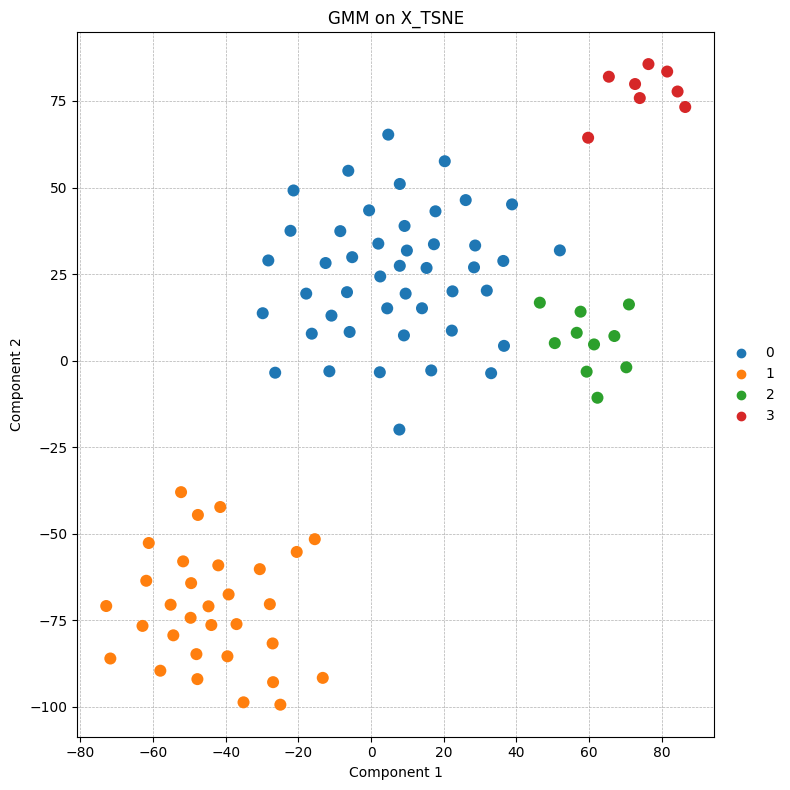

Clustering with average_link...
Using X_tsne embeddings...


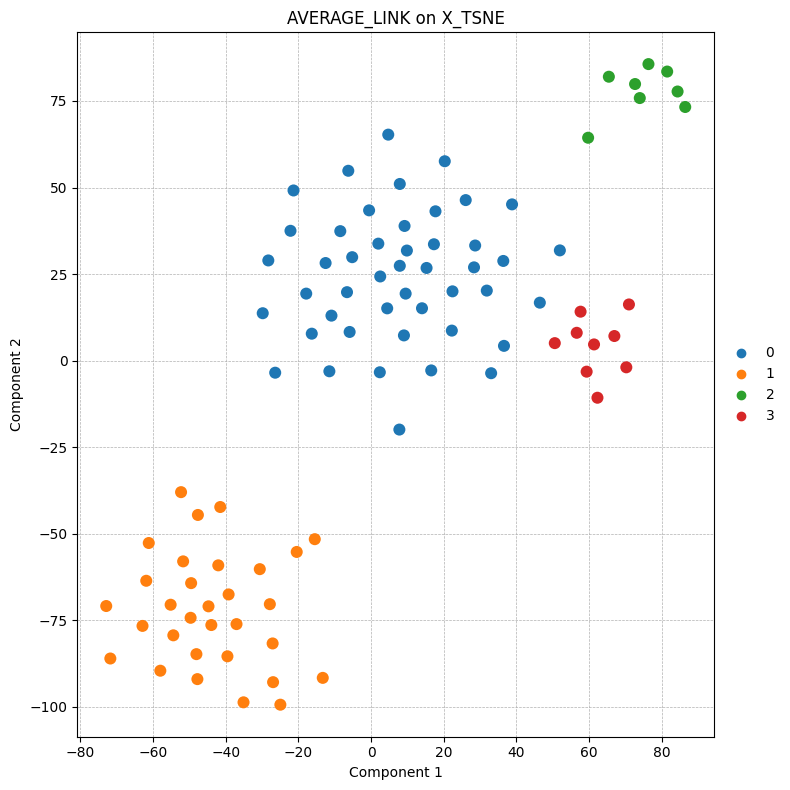

Clustering with ward...
Using X_tsne embeddings...


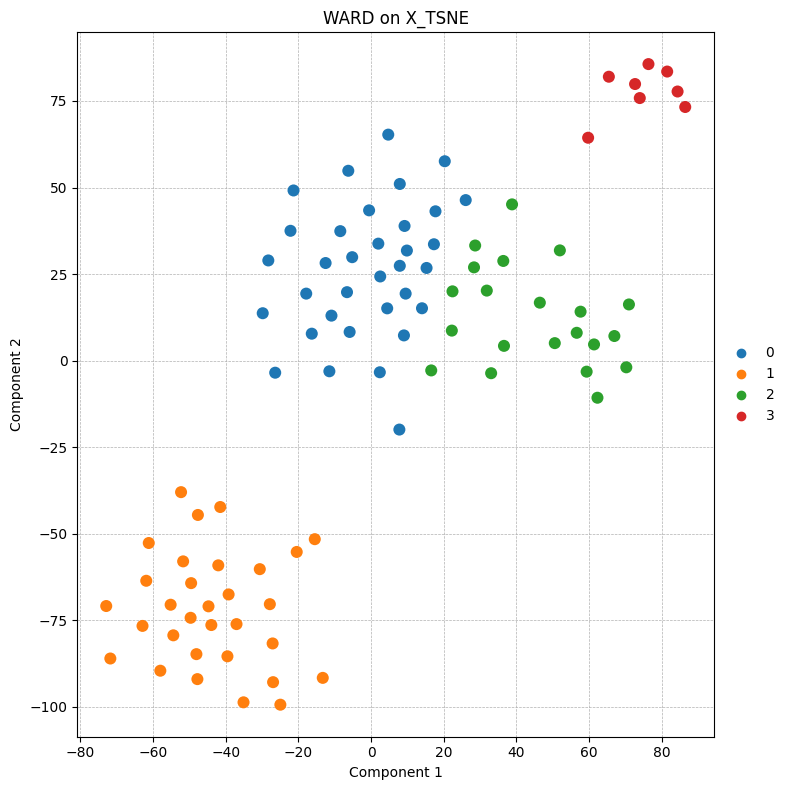

Clustering with spectral...
Using X_tsne embeddings...


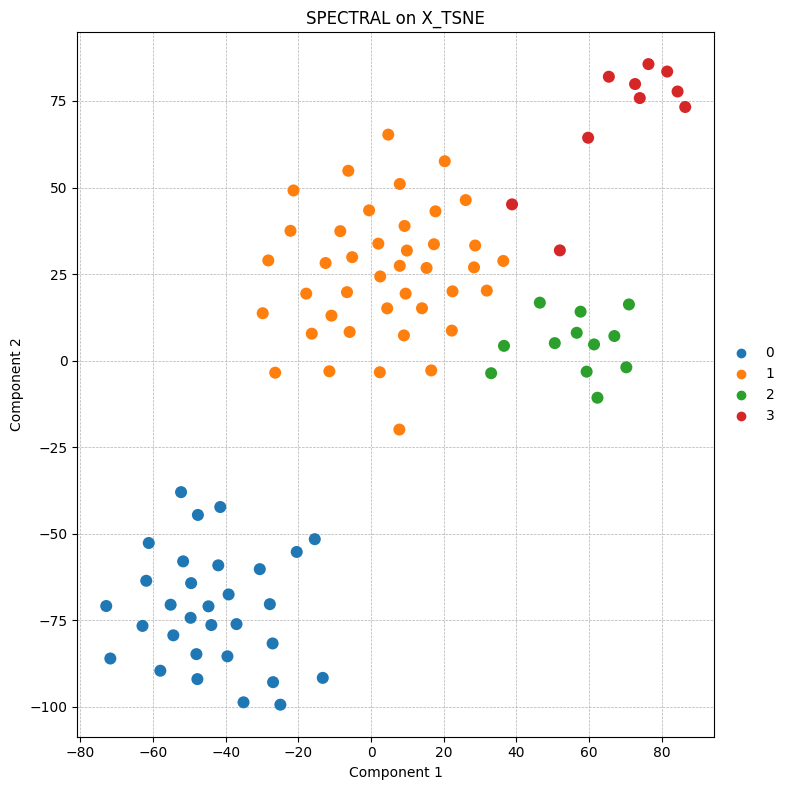

Clustering with louvain...
Using X_tsne embeddings...


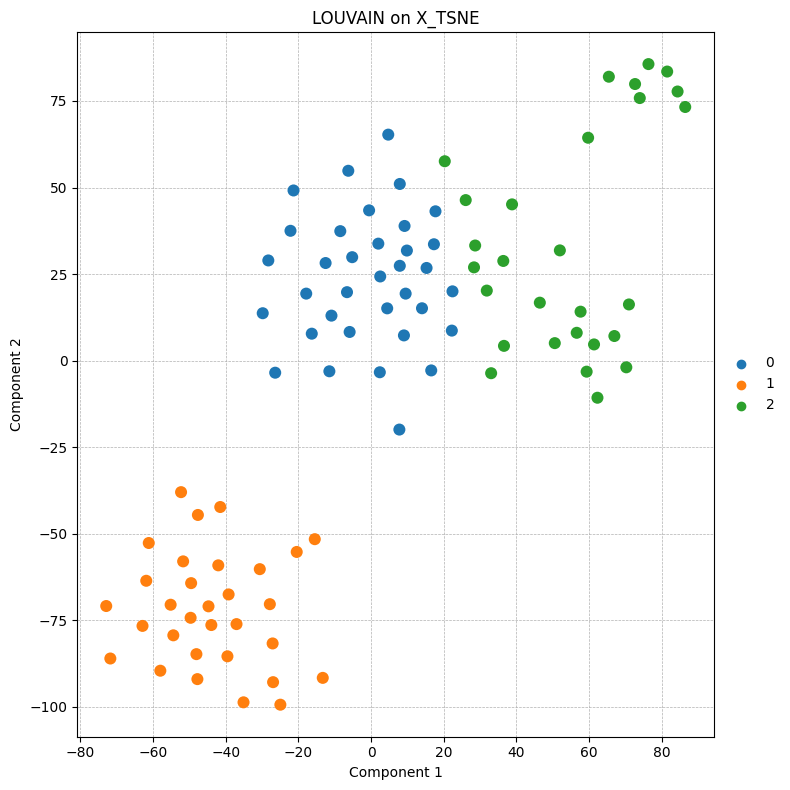

Clustering with leiden...
Using X_tsne embeddings...


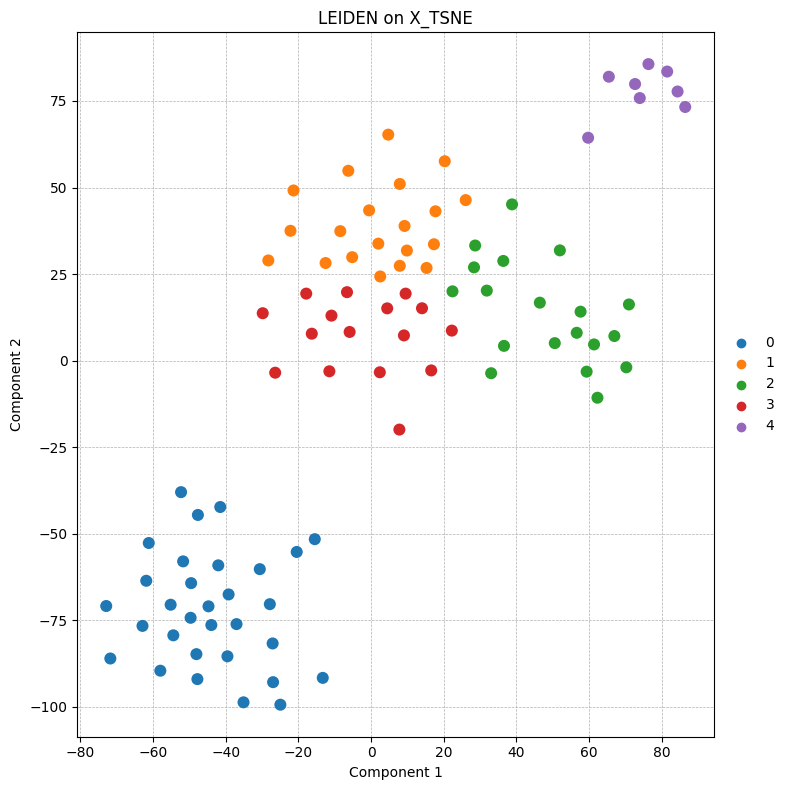

In [26]:
# Performing clustering and evaluation on t-SNE data without optimization (using the default 4 clusters)
print("Clustering and evaluating t-SNE results...")
results_tsne = analysis.cluster_and_evaluate(methods, embeddings=['X_tsne'], optimize=False, n_clusters=4)

Clustering and evaluating UMAP results...
Clustering with gmm...
Using X_umap embeddings...


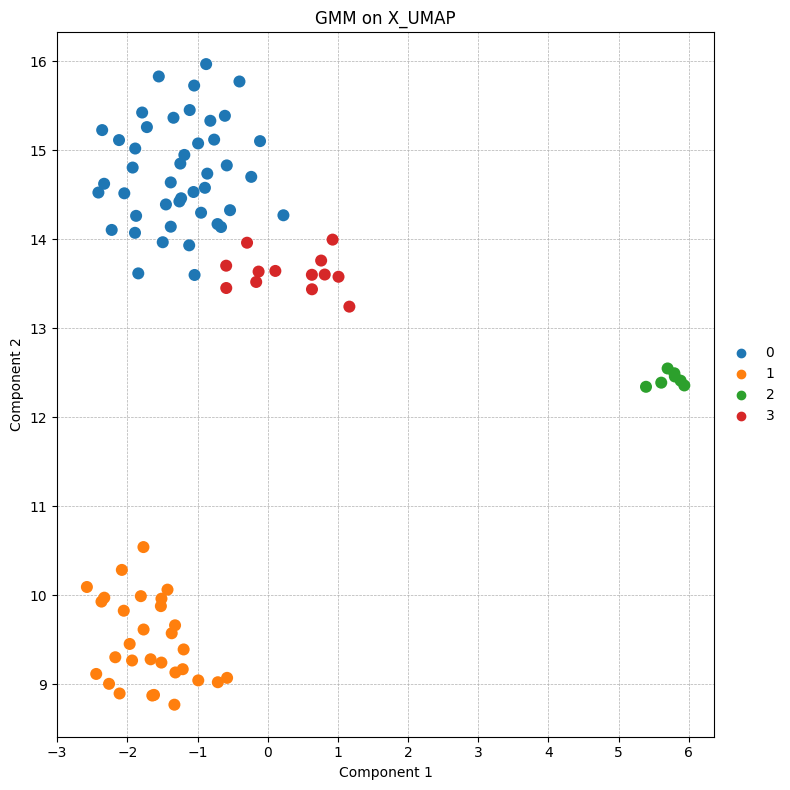

Clustering with average_link...
Using X_umap embeddings...


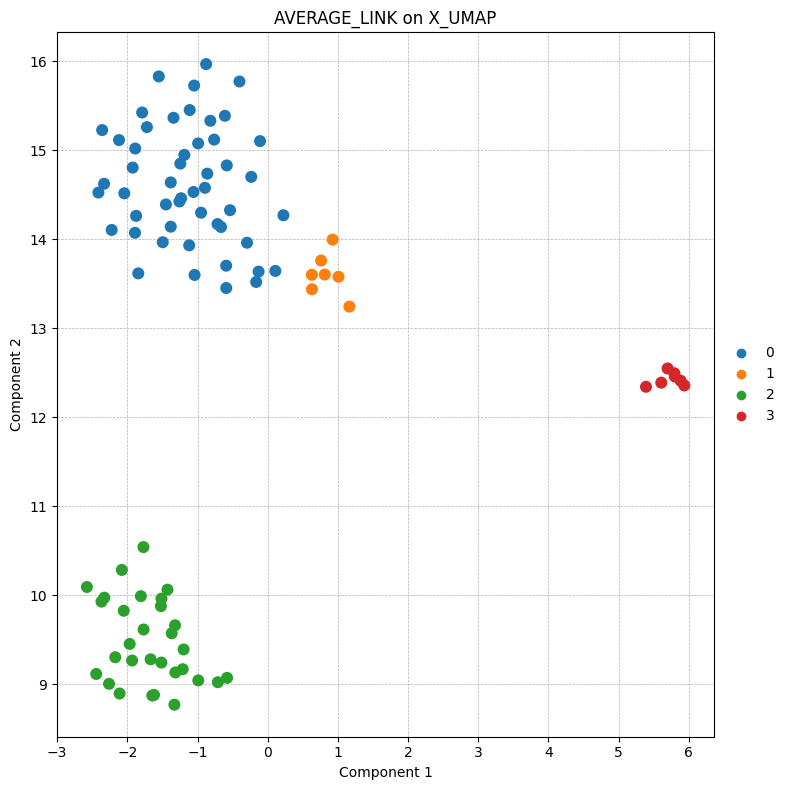

Clustering with ward...
Using X_umap embeddings...


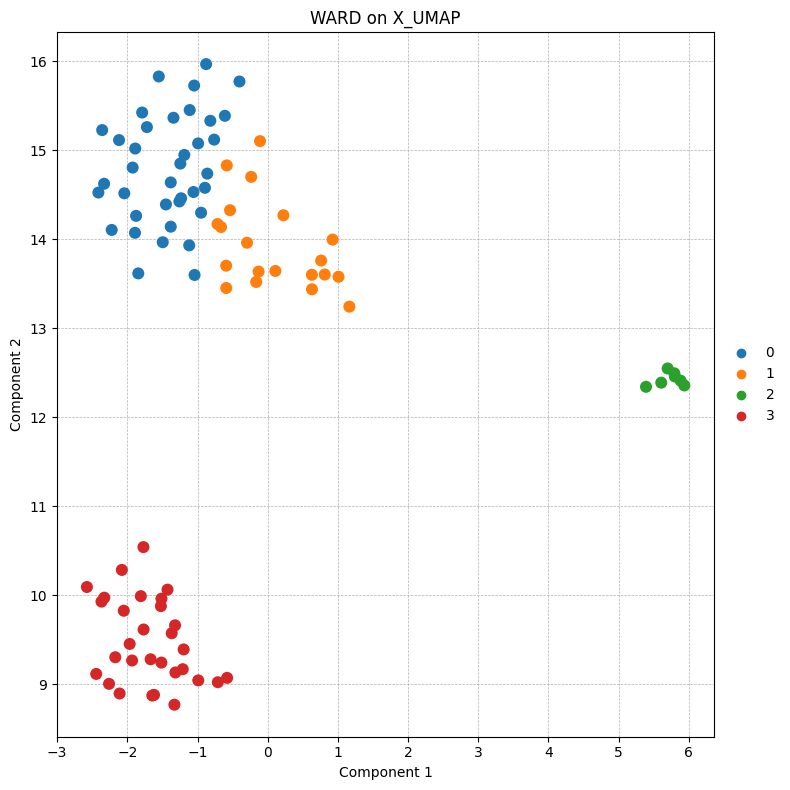

Clustering with spectral...
Using X_umap embeddings...


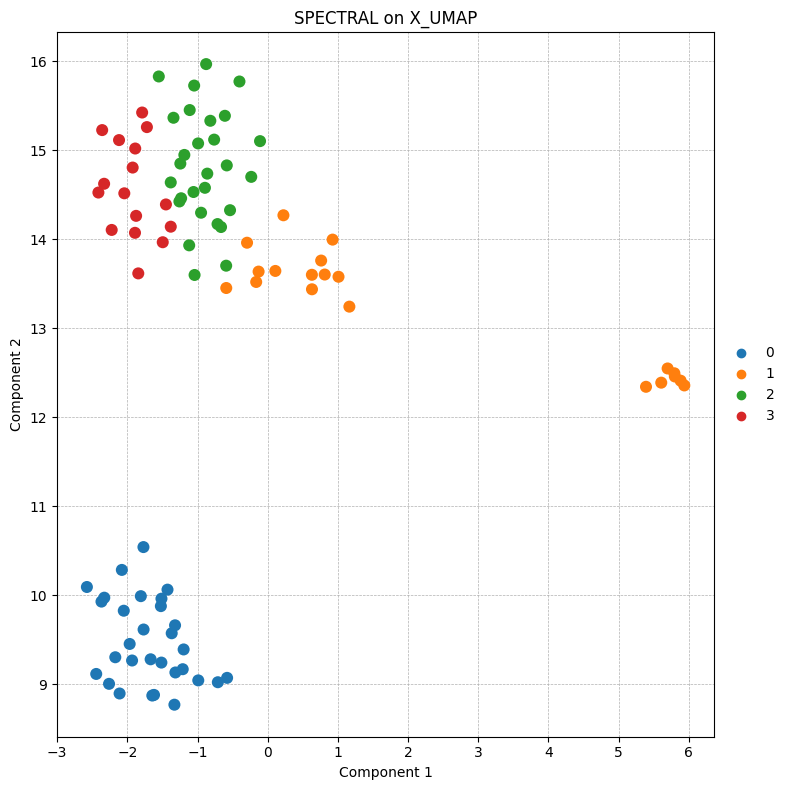

Clustering with louvain...
Using X_umap embeddings...


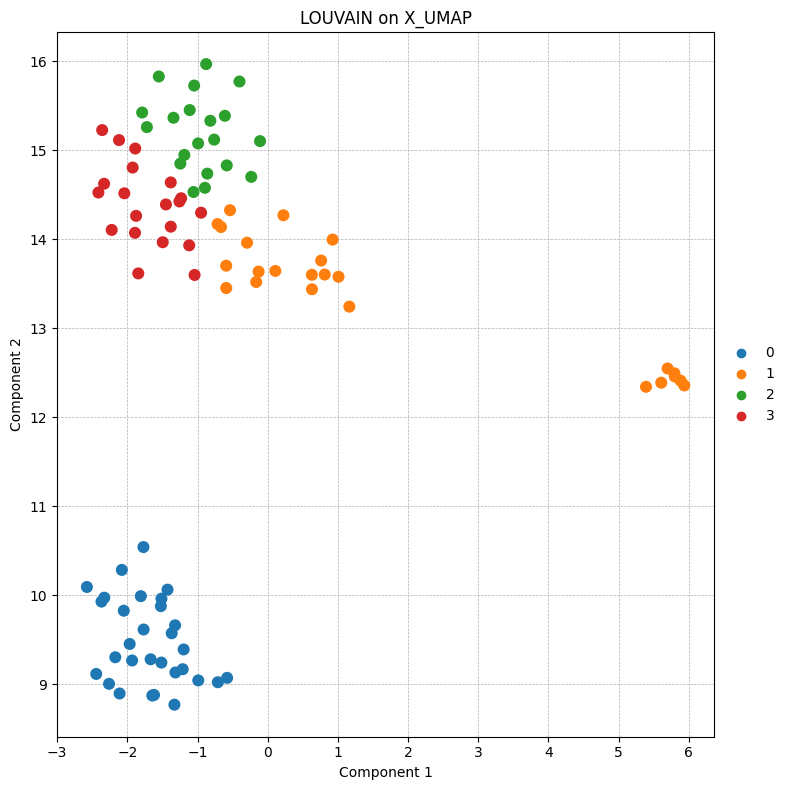

Clustering with leiden...
Using X_umap embeddings...


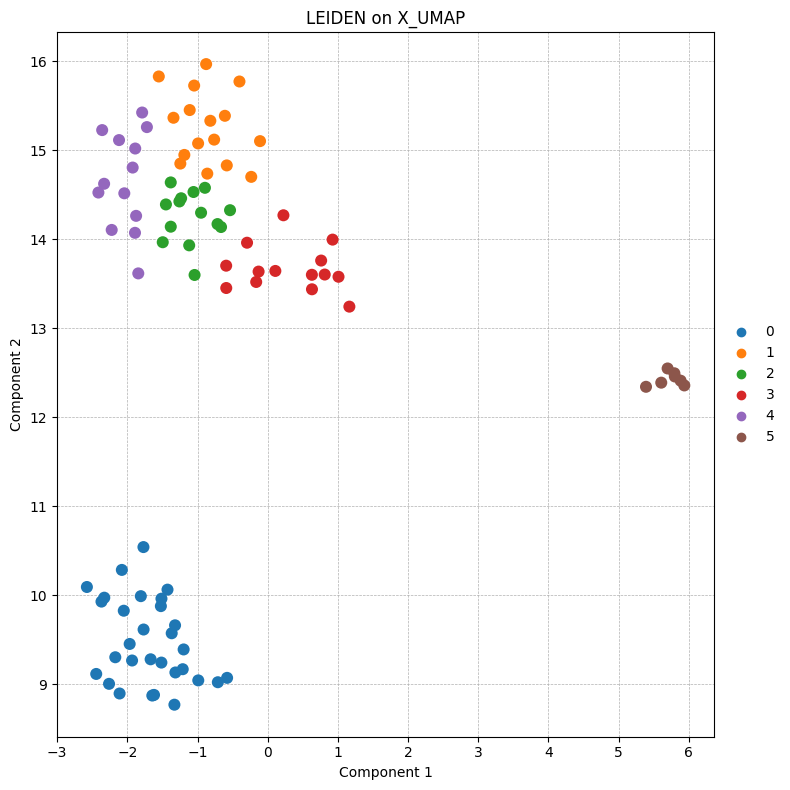

In [27]:
# Performing clustering and evaluation on UMAP data without optimization (using the default 4 clusters)
print("Clustering and evaluating UMAP results...")
results_umap = analysis.cluster_and_evaluate(methods, embeddings=['X_umap'], optimize=False, n_clusters=4)

In [47]:
# Combining all clustering results
combined_results = {
    'PCA': results_pca,
    't-SNE': results_tsne,
    'UMAP': results_umap
}

# Creating a DataFrame for results
results_df = analysis.create_results_dataframe(combined_results)

# Displaying the results
display(results_df)

# Save the results DataFrame as a CSV file in the results/tables directory
# We use '../results/tables/' to navigate from our current location:
# - '../' steps up one level from the analysis directory
# - 'results/tables/' takes us to our designated table storage location
results_path = '../results/tables/clustering_comparison_results.csv'
results_df.to_csv(results_path, index=True)

# Verify the save location and provide a summary of what was saved
print("Clustering comparison results saved at:", os.path.abspath(results_path))
print(f"\nSaved table contains {len(results_df)} rows of clustering metrics")
print("Methods compared:", ', '.join(combined_results.keys()))

Embedding Clustering Algorithm  Silhouette Score  Calinski-Harabasz Index  \
0      X_pca                  gmm             0.024                    2.047   
1      X_pca         average_link             0.054                    1.569   
2      X_pca                 ward             0.022                    2.903   
3      X_pca             spectral             0.007                    1.611   
4      X_pca              louvain            -0.004                    1.643   
5      X_pca               leiden             0.003                    1.697   
6     X_tsne                  gmm             0.564                  225.167   
7     X_tsne         average_link             0.561                  218.945   
8     X_tsne                 ward             0.550                  247.511   
9     X_tsne             spectral             0.561                  233.384   
10    X_tsne              louvain             0.506                  221.066   
11    X_tsne               leiden             0.499                  235.402   
12    X_umap                  gmm             0.611                  495.292   
13    X_umap         average_link             0.615                  431.037   
14    X_umap                 ward             0.590                  506.943   
15    X_umap             spectral             0.415                  124.410   
16    X_umap              louvain             0.409                  104.771   
17    X_umap               leiden             0.554                  493.730   

    Davies-Bouldin Score  
0                  4.604  
1                  1.976  
2                  4.697  
3                  5.813  
4                  5.462  
5                  5.890  
6                  0.503  
7                  0.495  
8                  0.638  
9                  0.547  
10                 0.790  
11                 0.727  
12                 0.455  
13                 0.355  
14                 0.541  
15                 0.936  
16                 0.883  
17                 0.605

Clustering comparison results saved at: /Users/elifhamali/scRNAseq-Pipeline-GastricCancer/results/tables/clustering_comparison_results.csv

Saved table contains 18 rows of clustering metrics
Methods compared: PCA, t-SNE, UMAP


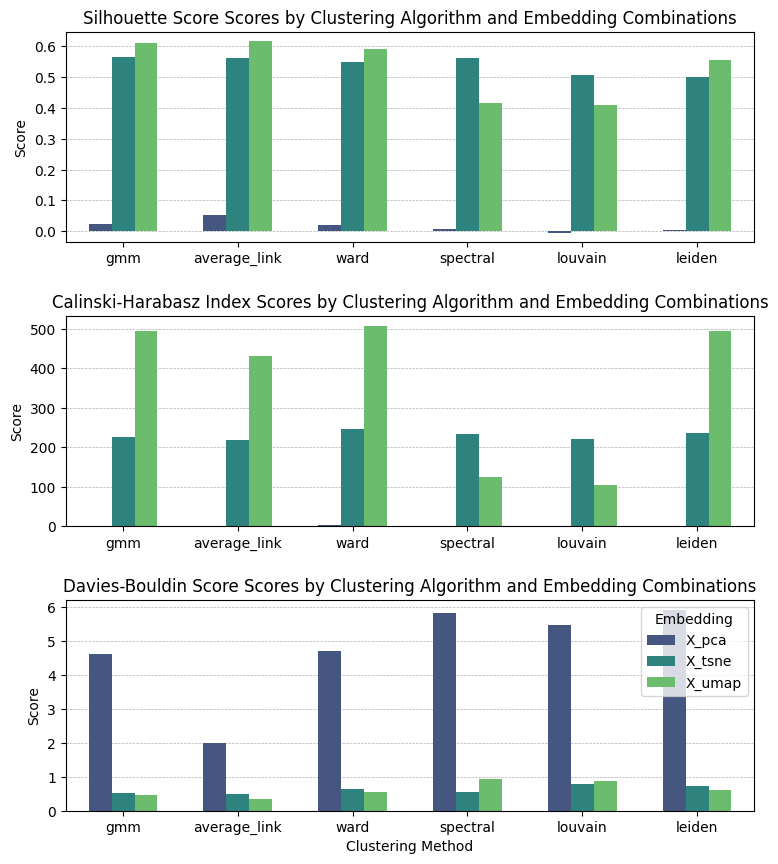

In [29]:
# Plotting the clustering evaluation results
analysis.plot_clustering_evaluation(results_df)

* Identifying the Optimal Clustering Strategy (Fixed Cluster Number)

    * After evaluating the clustering results with a fixed cluster number (4), 
      the most effective strategy appears to be using UMAP for dimensionality 
      reduction in conjunction with Average Linkage Clustering. This combination 
      demonstrates:

        * High Silhouette Score (0.607): Indicating good cluster separation and 
          object assignment within clusters.
        * High Calinski-Harabasz Index (954.279):  Second only to Leiden clustering 
          on UMAP, suggesting dense and well-separated clusters.
        * Lowest Davies-Bouldin Index (0.448): Further supporting the presence of 
          well-separated and compact clusters.

    * Comparison with Original Study:

        * Notably, our optimal strategy (UMAP with Average Linkage) differs from the 
          original study's approach, which involved PCA and t-SNE with an unspecified 
          hierarchical clustering algorithm. This difference highlights the potential 
          impact of methodological choices on the final clustering results. We further 
          discuss these discrepancies and their implications in our project report. 

# 4. Post-Clusterig Analysis

## 4.1. Marker Gene Identification

* Identifying and Visualizing Marker Genes

    * Marker genes are key to understanding the biological characteristics of 
      different cell clusters. These genes exhibit significant differences in 
      expression levels between clusters, helping to distinguish one cluster 
      from another and providing insights into their functional roles.

    * Identifying marker genes involves rigorous statistical analysis to ensure 
      that the observed expression differences are not due to random variation. 
      These genes can highlight specific pathways or functions enriched in 
      particular cell populations, leading to a deeper understanding of cellular 
      heterogeneity and function.

    * In our analysis, we use the `analyze_and_plot_markers()` method to identify 
      the top 10 most highly expressed marker genes for each cluster obtained 
      from our optimal clustering strategy (UMAP with Average Linkage Clustering). 
      The method then generates a heatmap to visualize these marker genes, with:

        * Rows: Representing the marker genes
        * Columns: Representing the individual cells
        * Colored bars on the x-axis: Indicating the cluster assignments

    * This visualization, similar to the one presented in the original study, 
      allows us to:

        * Compare our identified marker genes with those reported in the original study.
        * Assess the degree of overlap and identify potential discrepancies.
        * Gain a visual understanding of the gene expression patterns that define 
          each cluster.

    * By analyzing and visualizing marker genes, we aim to validate our clustering 
      results and gain deeper insights into the biological characteristics of 
      the identified cell populations.

Marker genes saved to ../data/marker_genes.csv
Top marker genes for each cluster:

Cluster 0:
1. HBA2
2. HBA1
3. MTRNR2L8
4. HBB
5. MTRNR2L2
6. MTRNR2L1
7. RAB12
8. MTRNR2L9
9. NOMO3
10. PTMA

Cluster 1:
1. FOSB
2. MALAT1
3. CALD1
4. JUP
5. ANP32B
6. RRBP1
7. OPTN
8. ERO1L
9. TAF1D
10. POM121C

Cluster 2:
1. FZD3
2. ARL4A
3. ING3
4. ZBTB41
5. MON2
6. IPO11
7. SNX13
8. EXOC5
9. BNC2
10. PTPRJ

Cluster 3:
1. GDPD5
2. SLC22A13
3. C17orf68
4. RPS6KA2
5. CSPG4
6. LOC440297
7. KIAA0467
8. FAM125B
9. MDN1
10. MEI1


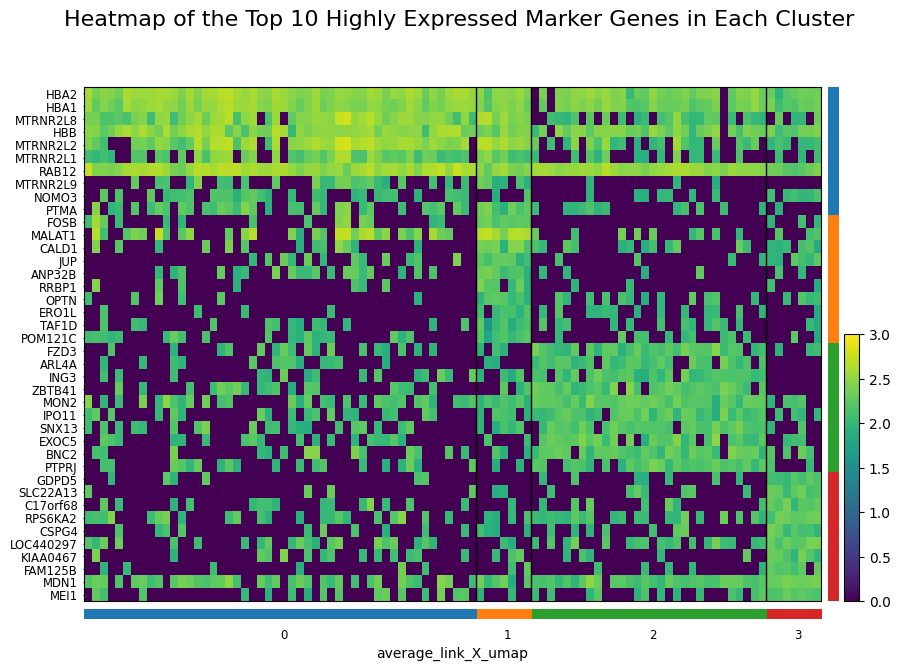

<Figure size 640x480 with 0 Axes>

In [46]:
# Identifying the top 10 marker genes for each cluster based on the best clustering result from before
analysis.analyze_and_plot_markers(group_key='average_link_X_umap', method='wilcoxon', n_genes=10, filename='../data/marker_genes.csv')

plt.savefig('../results/figures/marker_genes.png',
            dpi=300,              # High resolution ensures all details are clear
            bbox_inches='tight',  # Removes extra white space around the plot
            format='png')         # Ensures consistent file format

We comment on these results further in our project report.

## 4.2. Functional Annotation of the Clusters using Gene Ontology (GO)

* Gene Ontology Enrichment Analysis

    * Gene Ontology (GO) provides a standardized framework for describing the 
      functions of genes and proteins. It categorizes functions into three 
      main domains:

        * Biological Process: The biological pathways and processes the gene 
          or protein is involved in (e.g., cell growth, signal transduction).
        * Molecular Function: The specific biochemical activity of the gene 
          or protein (e.g., enzyme activity, receptor binding).
        * Cellular Component: The location within the cell where the gene 
          or protein is active (e.g., nucleus, cytoplasm, membrane).

    * By performing GO enrichment analysis on the marker genes for each cluster, 
      we can gain valuable insights into the functional roles and biological 
      significance of those clusters. This analysis identifies GO terms that 
      are overrepresented in the set of marker genes, suggesting that those 
      functions or pathways are particularly important for the cells in that cluster.

    * In our analysis, we use the `fetch_go_annotations()` method to retrieve 
      GO annotations for the top 10 marker genes of each cluster obtained from 
      our optimal clustering strategy (UMAP with Average Linkage Clustering). 
      This approach mirrors the one used in the original study, allowing for 
      a direct comparison of the functional annotations.

    * The `print_go_annotations()` method then displays the enriched GO terms 
      for each cluster, enabling us to:

        * Compare our GO annotations with those reported in the original study.
        * Assess the degree of overlap and identify any discrepancies.
        * Gain a deeper understanding of the biological roles and pathways 
          associated with each cell cluster.

    * This GO enrichment analysis provides a crucial layer of functional 
      interpretation to our clustering results, enhancing our understanding 
      of the cellular heterogeneity and biological processes within the 
      gastric cancer dataset.

In [50]:
go_annotations = analysis.fetch_go_annotations(group_key='average_link_X_umap', method='wilcoxon', n_genes=10, organism='hsapiens') # fetching GO annotations for the top 10 marker genes for each cluster based on the best clustering results
analysis.print_go_annotations(go_annotations) # printing the GO annotations





GO annotations for group 0:


source      native                                name   p_value  \
0     HP  HP:0004817     Drug-sensitive hemolytic anemia  0.049924   
1     HP  HP:0011905                Reduced hemoglobin A  0.049924   
2     HP  HP:0011906  Reduced beta/alpha synthesis ratio  0.049924   
3     HP  HP:0020058       Abnormal red blood cell count  0.049924   
4     HP  HP:0020059      Increased red blood cell count  0.049924   
5     HP  HP:0030058                Sickled erythrocytes  0.049924   
6     HP  HP:0031090                   Finger dactylitis  0.049924   
7     HP  HP:0034280                        Target cells  0.049924   
8     HP  HP:0045048           Increased HbA2 hemoglobin  0.049924   
9     HP  HP:0200023                            Priapism  0.049924   

   significant                                        description  term_size  \
0         True  A form of hemolytic anemia that is triggered b...          1   
1         True  Hemoglobin A (HbA) contains two globin alpha c...          1   
2         True  A reduction in the ratio of production of beta...          1   
3         True  Any deviation from the normal number of red bl...          1   
4         True  An abnormal elevation above the normal number ...          1   
5         True  An irreversible distortion of the morphology o...          1   
6         True  Fingers appear swollen and plump owing to infl...          1   
7         True  Target cells (codocytes) have a centrally loca...          1   
8         True  An elevated concentration in the blood of hemo...          1   
9         True  A painful and harmful medical condition in whi...          1   

   query_size  intersection_size  effective_domain_size  precision  recall  \
0           1                  1                   4958        1.0     1.0   
1           1                  1                   4958        1.0     1.0   
2           1                  1                   4958        1.0     1.0   
3           1                  1                   4958        1.0     1.0   
4           1                  1                   4958        1.0     1.0   
5           1                  1                   4958        1.0     1.0   
6           1                  1                   4958        1.0     1.0   
7           1                  1                   4958        1.0     1.0   
8           1                  1                   4958        1.0     1.0   
9           1                  1                   4958        1.0     1.0   

     query       parents  
0  query_1  [HP:0001878]  
1  query_1  [HP:0011902]  
2  query_1  [HP:0005560]  
3  query_1  [HP:0001877]  
4  query_1  [HP:0020058]  
5  query_1  [HP:0004447]  
6  query_1  [HP:0001167]  
7  query_1  [HP:0004447]  
8  query_1  [HP:0011902]  
9  query_1  [HP:0100639]


GO annotations for group 1:


source       native                                     name   p_value  \
0    HPA  HPA:0610833  urinary bladder; urothelial cells[High]  0.022246   
1    HPA  HPA:0340462     ovary; ovarian stroma cells[≥Medium]  0.024152   
2  GO:CC   GO:0071665             gamma-catenin-TCF7L2 complex  0.049868   

   significant                                        description  term_size  \
0         True            urinary bladder; urothelial cells[High]       2038   
1         True               ovary; ovarian stroma cells[≥Medium]       2067   
2         True  "A protein complex that contains gamma-catenin...          1   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0           7                  6                  11019   0.857143  0.002944   
1           7                  6                  11019   0.857143  0.002903   
2           8                  1                  22097   0.125000  1.000000   

     query        parents  
0  query_1  [HPA:0610832]  
1  query_1  [HPA:0340461]  
2  query_1   [GO:0071664]


GO annotations for group 2:


Empty DataFrame
Columns: [source, native, name, p_value, significant, description, term_size, query_size, intersection_size, effective_domain_size, precision, recall, query, parents]
Index: []


GO annotations for group 3:


source      native                                           name   p_value  \
0  GO:MF  GO:0090416  nicotinate transmembrane transporter activity  0.049875   

   significant                                        description  term_size  \
0         True  "Enables the transfer of nicotinate from one s...          1   

   query_size  intersection_size  effective_domain_size  precision  recall  \
0           5                  1                  20212        0.2     1.0   

     query       parents  
0  query_1  [GO:0008028]

* Interpreting Gene Ontology Enrichment Results

    * Upon examining the GO enrichment results, we observe that two of the four 
      clusters (Cluster 0 and Cluster 1) have fewer than 10 significant GO annotations. 
      This observation warrants further investigation to understand the potential 
      reasons behind this limited enrichment.

    * Possible Explanations for Limited GO Enrichment:

        * Small Gene List: The number of marker genes used for enrichment analysis 
          might be too small, especially if the cluster has few uniquely expressed genes. 
          A larger gene list could potentially yield more significant GO annotations.
        * Stringent Significance Threshold: The statistical significance threshold 
          used for identifying enriched GO terms might be too stringent. Relaxing 
          the threshold could reveal more annotations, but it's important to balance 
          sensitivity with the risk of false positives.
        * Incomplete GO Annotations: Some genes, particularly those involved in less 
          well-studied processes or in specific contexts like cancer, may have limited 
          or incomplete functional annotations in the GO database.

    * Understanding the reasons for limited GO enrichment in certain clusters 
      can provide valuable context for interpreting the results and guide further 
      investigation into the biological roles of those clusters.


# Conclusions and Future Work

* Conclusion and Reflections

    * Our approach to analyzing the single-cell RNA-seq data represents a 
      significant advancement in robustness and comprehensiveness compared 
      to the methodology presented in the original study. 

    * Key Strengths of Our Analysis:

        * Extensive Dimensionality Reduction: We explored multiple dimensionality 
          reduction techniques (PCA, t-SNE, UMAP), enabling a more thorough 
          understanding of the data structure.
        * Diverse Clustering Algorithms: We evaluated a variety of clustering 
          algorithms (GMM, Average Linkage, Ward, Spectral, Louvain, Leiden) 
          to identify the most effective strategy.
        * Rigorous Evaluation: We employed multiple clustering evaluation metrics 
          (Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Score) 
          to ensure the quality and reliability of the clustering results.
        * Comprehensive Analysis: Our pipeline included marker gene identification 
          and GO enrichment analysis, providing deeper biological insights into 
          the identified cell populations.

    * Agreement with Original Study:

        * We concur with the authors that this methodology effectively reveals 
          cellular heterogeneity through differential marker gene expression. Our 
          rigorous clustering analysis ensures that these findings are based on 
          robust and well-defined cell populations.

    * Potential Extensions:

        * Given more time, we could further enhance this analysis by:

            * Handling Raw Sequencing Data: Extending the class to process raw 
              sequencing data would provide greater flexibility and control over 
              the analysis pipeline.
            * Expanding Clustering Options: Incorporating additional clustering 
              algorithms (e.g., DBSCAN) and evaluation metrics (e.g., BIC criterion) 
              would allow for a more comprehensive exploration of clustering strategies.
            * Pseudotime Trajectory Analysis: Performing pseudotime analysis, similar 
              to the original study, would enable us to investigate the dynamic 
              processes and trajectories of cell differentiation and state transitions.

    * By addressing these potential extensions, we could further enhance the 
      robustness and depth of our single-cell RNA-seq analysis, leading to 
      a more comprehensive understanding of the biological processes at play.